In [ ]:
!pip install transformers
!pip install gensim

In [ ]:
import pandas as pd
import numpy as np
import re
import random
import torch
import string
import pickle
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import xgboost as xgb
import seaborn as sns

from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.doc2vec import Doc2Vec
from gensim.models import Word2Vec
from gensim.models.fasttext import FastText
import gensim.downloader as api


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive # access google drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##load data

In [ ]:
test_data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Hakaton-LLM/Ensemble/test.csv')
test_data

abstract
0       Probabilistic principal component analysis (...
1       Sensor-based degradation signals measure the...
2       The generic identification problem is to dec...
3       We introduce a new class of lower bounds on ...
4       Regularization is a powerful technique for e...
...                                                 ...
3931    The goal of cross-domain object matching (CD...
3932    Sequential prediction problems such as imita...
3933    Minimizing the relative inertia of a statist...
3934    The 2004 US Presidential Election cycle mark...
3935    The class of Schoenberg transformations, emb...

[3936 rows x 1 columns]

In [ ]:
train_data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Hakaton-LLM/Ensemble/train.csv')
train_data

abstract category
0     In the last four years, daily deals have eme...  Applied
1     We propose a novel approach for density esti...       ML
2     In this research, two-state Markov switching...  Applied
3     This article considers the estimation of the...  Applied
4     Markowitz's celebrated mean--variance portfo...  Applied
..                                                ...      ...
59    The use of Reinforcement Learning in real-wo...       ML
60    The paper introduces a penalized matrix esti...       ML
61    Cross-validation (CV) is widely used for tun...  Applied
62    We analyze the results of the German Team Ha...  Applied
63    In this paper we consider sparse and identif...       ML

[64 rows x 2 columns]

##preprocess data

`Text Cleaning`


In text cleaning I have used below steps:

Removing white extra space from text
Removed all special characters from the text
Removed all single characters from the text
Converted text to lower case
Word tokenization
Lemmatization
Remove stop words from the text
Removed words length less than 3 from text![1.png](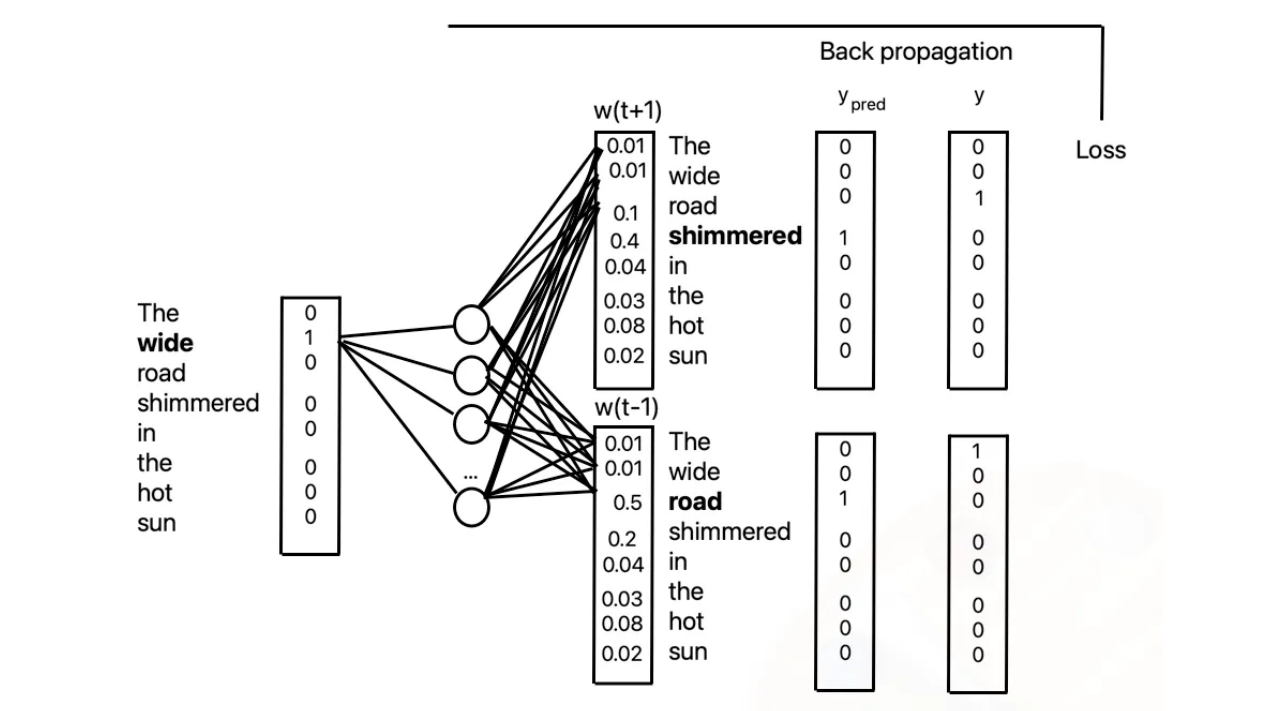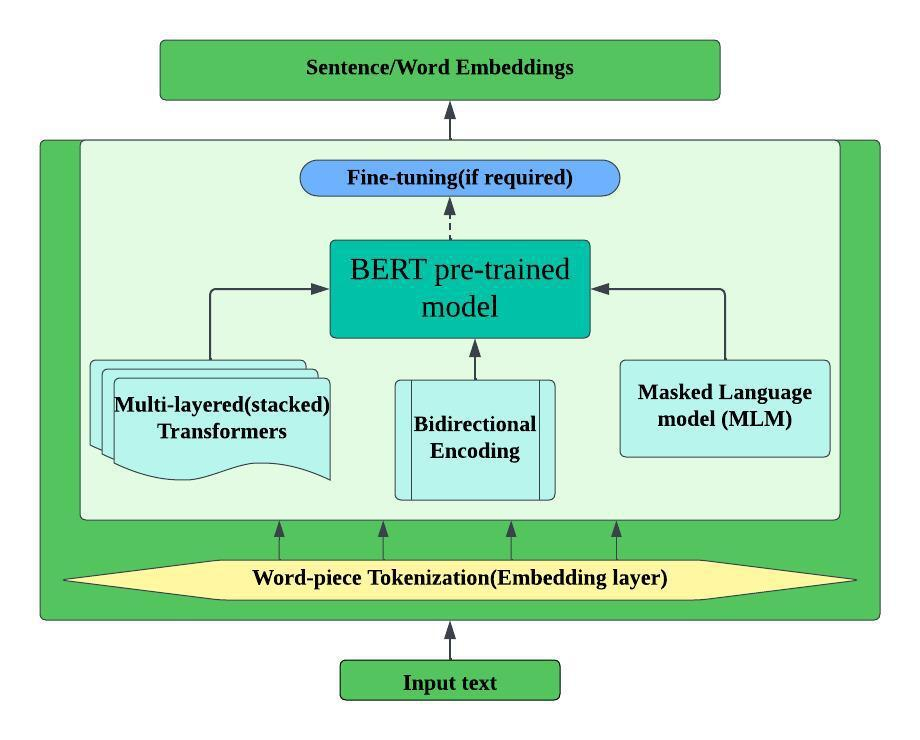)

In [ ]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in STOPWORDS])

def remove_spl_chars(text):
    text = re.sub('[^a-zA-Z0-9]', ' ', text)
    text = re.sub('\s+', ' ', text)
    return text

def process_text(document):

        # Remove extra white space from text
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Remove all the special characters from text
        document = re.sub(r'\W', ' ', str(document))

        # Remove all single characters from text
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Converting to Lowercase
        document = document.lower()

        # Word tokenization
        tokens = document.split()
        # Lemmatization using NLTK
        lemma_txt = [stemmer.lemmatize(word) for word in tokens]
        # Remove stop words
        lemma_no_stop_txt = [word for word in lemma_txt if word not in en_stop]
        # Drop words
        tokens = [word for word in tokens if len(word) > 3]

        clean_txt = ' '.join(lemma_no_stop_txt)

        return clean_txt

In [ ]:
train_data['clean_text'] = train_data['abstract'].str.lower()
train_data['clean_text'] = train_data['clean_text'].apply(lambda x: remove_stopwords(x))
train_data['clean_text'] = train_data['clean_text'].apply(lambda x: remove_spl_chars(x))

train_data.head()

abstract category  label  \
0    In the last four years, daily deals have eme...  Applied      0   
1    We propose a novel approach for density esti...       ML      1   
2    In this research, two-state Markov switching...  Applied      0   
3    This article considers the estimation of the...  Applied      0   
4    Markowitz's celebrated mean--variance portfo...  Applied      0   

                                          clean_text  
0  last four years daily deals emerged nowhere be...  
1  propose novel approach density estimation expo...  
2  research two state markov switching models pro...  
3  article considers estimation number severely d...  
4  markowitz s celebrated mean variance portfolio...

In [ ]:
test_data['clean_text'] = test_data['abstract'].str.lower()
test_data['clean_text'] = test_data['clean_text'].apply(lambda x: remove_stopwords(x))
test_data['clean_text'] = test_data['clean_text'].apply(lambda x: remove_spl_chars(x))

test_data.head()

abstract  \
0    Probabilistic principal component analysis (...   
1    Sensor-based degradation signals measure the...   
2    The generic identification problem is to dec...   
3    We introduce a new class of lower bounds on ...   
4    Regularization is a powerful technique for e...   

                                          clean_text  
0  probabilistic principal component analysis ppc...  
1  sensor based degradation signals measure accum...  
2  generic identification problem decide whether ...  
3  introduce new class lower bounds log partition...  
4  regularization powerful technique extracting u...

In [ ]:
train_x = train_data['clean_text'].tolist()
train_y = train_data['category'].tolist()
text_x = test_data['clean_text'].tolist()

In [ ]:
label_dict = {'ML':0, 'Applied':1}
reverse_dict = {0:'ML', 1:'Applied'}

#Map string labels to integers
train_y = [label_dict[y] for y in train_y]

In [ ]:
sentense = train_data['clean_text'] + " " +  train_data['clean_text'] + " " +train_data['category']
sentense = sentense.tolist()

In [ ]:
en_stop = set(nltk.corpus.stopwords.words('english'))
stemmer = WordNetLemmatizer()

clean_corpus = [process_text(sentence) for sentence in tqdm(sentense) if sentence.strip() !='']

100%|██████████| 64/64 [00:02<00:00, 28.27it/s]


#Text to Features

"**`Feature`**" is the name given to selected or treated data that is prepared to be used as input for algorithms (usually Machine Learning Algorithms).

The techniques used to turn **`text into features`** can be referred to as "**`Text Vectorization`**" techniques since they all aim for one purpose: turning text into vectors (or arrays, if you want it simpler; or tensors, if you want it more complex) that can then be fed to machine learning models in a classical way.

Overview of text vectorization methods :

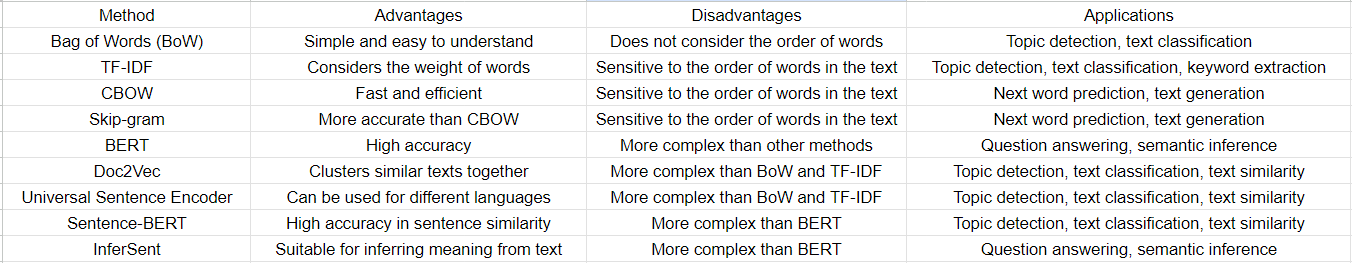

##Bag of Words (BoW)

This model is called a "**`Bag`**" because it does not preserve word order, similar to how our mothers' bags in the 90s were always messy.

 The BOW technique works by creating an array or dictionary of all the words in a sentence. Each word in the dictionary is assigned a value of 1 if it appears in the input sentence, and 0 otherwise.

**Step 1: Collect Data**

*  It was the best of times
*  it was the worst of times
*  it was the age of wisdom
*  it was the age of foolishness


**Step 2: Design the Vocabulary**

The unique words here (ignoring case and punctuation) are:

*   “it”

*   “was”

*   “the”

*   “best”

*   “of”

*   “times”

*   “worst”

*   “age”

*   “wisdom”

*   “foolishness”

**Step 3: Create Document Vectors**

*   "it was the worst of times" = [1, 1, 1, 0, 1, 1, 1, 0, 0, 0]

*   "it was the age of wisdom" = [1, 1, 1, 0, 1, 0, 0, 1, 1, 0]

*   "it was the age of foolishness" = [1, 1, 1, 0, 1, 0, 0, 1, 0, 1]


In [ ]:
# Create BOW model
vectorizer = CountVectorizer()
vectorizer.fit(train_x)

# Save BOW model
with open ('bow.pk', 'wb') as vocabFile:
    pickle.dump(vectorizer, vocabFile)

# Load BOW model and transform text into bow
loaded_vocabulary = pickle.load(open("bow.pk", "rb"))
bow = loaded_vocabulary.transform(train_x).todense()
print(bow)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
bow_test = loaded_vocabulary.transform(text_x).todense()
print(bow_test)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
x = np.array(bow)
y = np.array(train_y)
x_test = np.array(bow_test)

model_1 = LinearRegression()
model_1.fit(x, y)

model_2 = xgb.XGBRegressor()
model_2.fit(x, y)

model_3 = RandomForestRegressor()
model_3.fit(x, y)

pred_1 = model_1.predict(x_test)
pred_2 = model_2.predict(x_test)
pred_3 = model_3.predict(x_test)

pred_final = (pred_1+pred_2+pred_3)/3.0

predictions = np.where(pred_final > 0.5, 1, 0)
predictions

array([1, 0, 1, ..., 0, 1, 1])

In [ ]:
data = {'prediction': predictions}
df = pd.DataFrame(data)
df = df.replace({1: 'ML', 0: 'Applied'})
print(df)

     prediction
0            ML
1       Applied
2            ML
3            ML
4       Applied
...         ...
3931    Applied
3932         ML
3933    Applied
3934         ML
3935         ML

[3936 rows x 1 columns]


In [ ]:
df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Hakaton-LLM/Ensemble/output.csv', index=False)

**problems in the model:**

**First:** it ignores word `order` completely.

**Second:** It tends to be very `high dimensional`. If your corpus accounts only the 90% most common English words at least once, according to the Oxford English Corpus, that’ll result in a vector of at least 7000 dimensions (most of which will be of zeroes, but is a lot of dimensions, nonetheless)!

#Term Frequency–Inverse Document Frequency (TFIDF)

**TF (Term Frequency)** measures the frequency of a term within a document. It indicates how often a particular term appears in the document. A higher TF score suggests that the term is more important within that document.

**IDF (Inverse Document Frequency)** measures the rarity or uniqueness of a term across a collection of documents. It calculates the logarithm of the inverse fraction of documents that contain the term. Terms with a high IDF score are considered to have more significance as they appear in a limited number of documents.

**Step 1: Collect Data**

*  It was the best of times
*  it was the worst of times
*  it was the age of wisdom
*  it was the age of foolishness

**Step 2: Clean data and Tokenize**

The unique words here (ignoring case and punctuation) are:

*   "it": 4
*   "was": 4
*   "the": 4
*   "best": 1
*   "of": 4
*   "times": 2
*   "worst": 1
*   "age": 2
*   "wisdom": 1
*   "foolishness": 1


**Step 3: TF scores**

$$
TF = \frac{(Number\ of\ repetitions\ of\ word\ in\ a\ document)}{(Number\ of\ words\ in\ a\ document)}
$$



*   "it": 4/23 = 0.174
*   "was": 4/23 = 0.174
*   "the": 4/23 = 0.174
*   "best": 1/23 = 0.043
*   "of": 4/23 = 0.174
*   "times": 2/23 = 0.087
*   "worst": 1/23 = 0.043
*   "age": 2/23 = 0.087
*   "wisdom": 1/23 = 0.043
*   "foolishness": 1/23 = 0.043

**Step 4 IDF scores**

$$
IDF = Log\frac{(Number\ of\ document)}{(Number\ of\ documents\ containing\ the\ word)}
$$

*   "it": IDF = log(4 / 4) = 0
*   "was": IDF = log(4 / 4) = 0
*   "the": IDF = log(4 / 4) = 0
*   "best": IDF = log(4 / 1) = 2
*   "of": IDF = log(4 / 4) = 0
*   "times": IDF = log(4 / 2) = 1.4
*   "worst": IDF = log(4 / 1) = 2
*   "age": IDF = log(4 / 2) = 1.4
*   "wisdom": IDF = log(4 / 1) = 2
*   "foolishness": IDF = log(4 / 1) = 2

**Step 4 TF-IDF scores**
$$
TF\_IDF = TF \times IDF
$$

*   "it": 0.174 * 0 = 0
*   "was": 0.174 * 0 = 0
*   "the": 0.174 * 0 = 0
*   "best": 0.043 * 2 = 0.086
*   "of": 0.174 * 0 = 0
*   "times": 0.087 * 1.4 = 0.122
*   "worst": 0.043 * 2 = 0.086
*   "age": 0.087 * 1.4 = 0.122
*   "wisdom": 0.043 * 2 = 0.086
*   "foolishness": 0.043 * 2 = 0.086

**Step 5: Create Document Vectors**
*   "It was the best of times" =
[0, 0, 0, 0.086, 0, 0.122, 0, 0.122, 0.086, 0.086]

*   "it was the worst of times"=
[0, 0, 0, 0.086, 0, 0.122, 0.086, 0.122, 0, 0]

*   "it was the age of wisdom"=
[0, 0, 0, 0, 0, 0, 0, 0.122, 0.086, 0]

*   "it was the age of foolishness"=
[0, 0, 0, 0, 0, 0, 0.086, 0.122, 0, 0.086]

In [ ]:
# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer on the training data and transform the training data
X_train_tfidf = vectorizer.fit_transform(train_x)
# Transform the test data
X_test_tfidf = vectorizer.transform(text_x)

In [ ]:
x = X_train_tfidf
y = np.array(train_y)
x_test = X_test_tfidf

model_1 = LinearRegression()
model_1.fit(x, y)

model_2 = xgb.XGBRegressor()
model_2.fit(x, y)

model_3 = RandomForestRegressor()
model_3.fit(x, y)

pred_1 = model_1.predict(x_test)
pred_2 = model_2.predict(x_test)
pred_3 = model_3.predict(x_test)

pred_final = (pred_1+pred_2+pred_3)/3.0

predictions = np.where(pred_final > 0.5, 1, 0)
predictions

array([1, 1, 1, ..., 0, 1, 1])

In [ ]:
data = {'prediction': predictions}
df = pd.DataFrame(data)
df = df.replace({1: 'ML', 0: 'Applied'})
print(df)

     prediction
0            ML
1            ML
2            ML
3            ML
4       Applied
...         ...
3931         ML
3932         ML
3933    Applied
3934         ML
3935         ML

[3936 rows x 1 columns]


**problems in the model:**

If you use `BOW` or `TF-IDF`, sooner or later you will find a big problem which is `matrix size`. Since BOW and TF-IDF matrix size is determined by the number of word in dictionary, the bigger your dictionary the bigger matrix size of both technique.

#Word2Vec

Word2Vec offers a solution to this problem by `reducing the dimensionality` of the word representation. Instead of creating a large matrix, Word2Vec uses a neural network to learn the underlying features of each word. The neural network learns to predict the context of a word based on its neighboring words or vice versa. This process helps capture the relationships between words in a meaningful way.

word2vec is `unsupervised learning algorithms` for generated word embeddings.

One of the advantages of Word2Vec is that it can `capture semantic relationships` between words.

There are two flavors of this algorithm namely:

*   CBOW
*   Skip-Gram



Given a set of sentences (also called corpus) the model loops on the words of each sentence and either tries to use the current word w in order to predict its neighbors, this approach is called `Skip-Gram`, or it uses each of these contexts to predict the current word w, in that case the method is called `Continuous Bag Of Words (CBOW)`. To limit the number of words in each context, a parameter called `window size` is used.

**Word embeddings** are important for many NLP tasks because they capture semantic and syntactic relationships between words in a language.

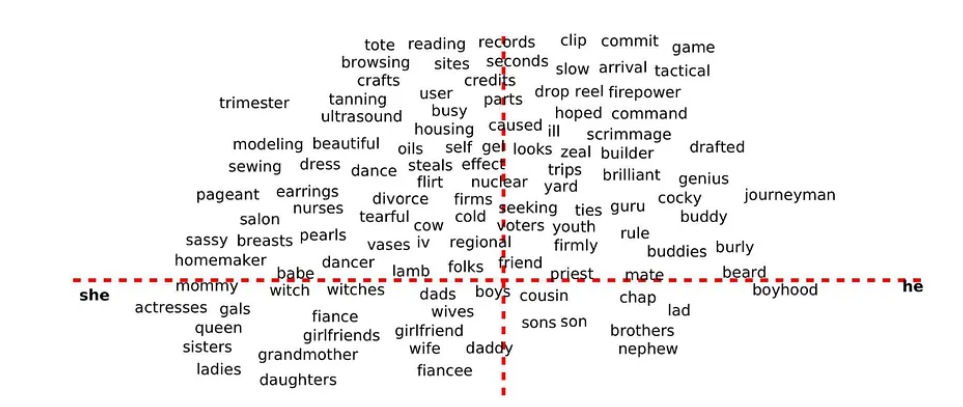

###CBOW
`CBOW` is a feedforward neural network-based algorithm that predicts a target word given its surrounding context words. It is a type of `“unsupervised” learning`, meaning that it can learn from unlabeled data, and it is often used to pre-train word embeddings that can be used for various NLP tasks such as `sentiment analysis`, `text classification`,`Named Entity Recognition`,`Information Retrieval` and `machine translation`.

The `CBOW` model is a neural network-based approach that captures the context of words. It learns to predict the target word based on the words that appear before and after it in a given context window. By considering the surrounding words, the `CBOW` model can better capture the meaning of a word in a given context.

`CBOW` focuses on predicting a central word based on the surrounding words.

**Input Layer:** The input layer represents the context words. The number of input neurons is determined by the size of the context window, which specifies how many words should be `considered to the left and right of the target word`.

**Projection Layer:** In the projection layer, each input word is converted into a dense, `fixed-size vector` representation. These word vectors are known as word embeddings and are learned during the training process.

**Hidden Layer:** The hidden layer contains one or more neurons, and its purpose is to capture the relationships between the context words and the target word. This layer performs a `linear transformation` on the word embeddings.

**Output Layer:** The output layer consists of as many neurons as there are unique words in the vocabulary. Each output neuron corresponds to a specific word in the vocabulary, and the softmax activation function is applied to produce a probability distribution over the vocabulary.

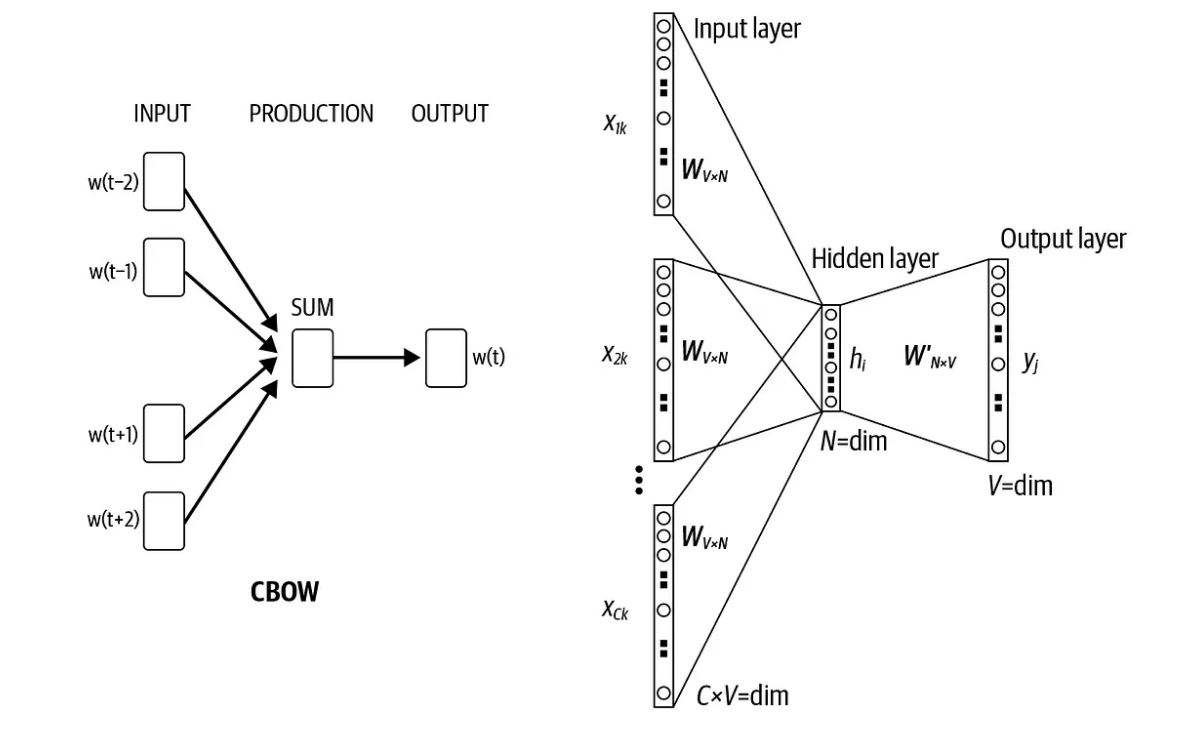

**Training the CBOW Model**


**Data Preparation:** A large text corpus is required to train the CBOW model. The text is divided into sentences and tokenized into words.

**Context-Target Pairs:** For each word in the training corpus, a context window of a fixed size is defined, and the surrounding words are used as input (context) to predict the target word.

**Word Embedding Learning:** During training, the model optimizes its parameters to minimize the cross-entropy loss between the predicted probabilities and the actual target word’s one-hot encoded representation. This optimization results in learning word embeddings in the projection layer that capture semantic relationships between words.

**Evaluation:** The quality of the learned word embeddings can be evaluated using tasks such as word similarity, analogy detection, and even downstream NLP tasks like sentiment analysis and part-of-speech tagging.




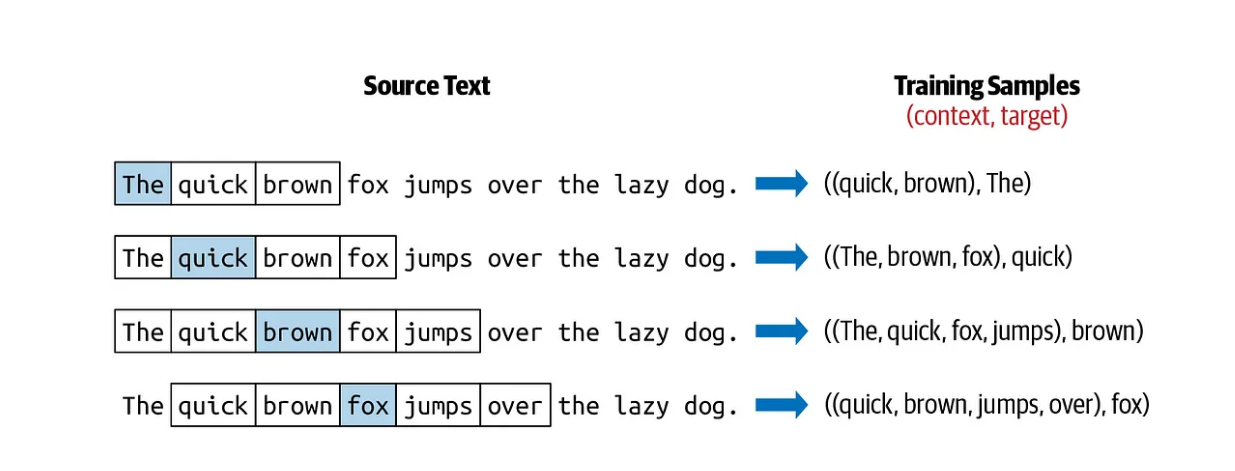

In [ ]:
words = " ".join(sentense).split()
vocab = list(set(words))
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
V = len(vocab)
context_window = 1
word_vectors = np.random.uniform(0, 1, (V, 100)) #random.uniform(low, high, size), Draw samples from a uniform distribution.

In [ ]:
len(vocab)

3101

In [ ]:
# Function to generate context-target pairs
def generate_cbow_data(corpus, context_window, word_to_idx):
    data = []
    for sentence in corpus:
        sentence = sentence.split() #tokenization
        for target_word_idx, target_word in enumerate(sentence):
            for context_word_idx in range(
                max(0, target_word_idx - context_window),
                min(len(sentence), target_word_idx + context_window + 1),
            ):
                if context_word_idx != target_word_idx:
                    context_word = sentence[context_word_idx]
                    target = word_to_idx[target_word]
                    context = word_to_idx[context_word]
                    data.append((context, target))
    return data

In [ ]:
# Training CBOW model
learning_rate = 0.01
epochs = 1

for epoch in range(epochs):
    total_loss = 0
    data = generate_cbow_data(train_x, context_window, word_to_idx)
    for context, target in data:
        context_vector = word_vectors[context]
        predicted = np.dot(context_vector, word_vectors.T)
        y = np.zeros(V)
        y[target] = 1
        error = y - predicted
        total_loss += np.sum(error ** 2)
        for j in range(V):
            word_vectors[j] += learning_rate * error[j] * context_vector

    if (epoch + 1) % 1 == 0:
        print(f"Epoch {epoch + 1}, Loss: {total_loss}")


Epoch 1, Loss: 6326201.067534677


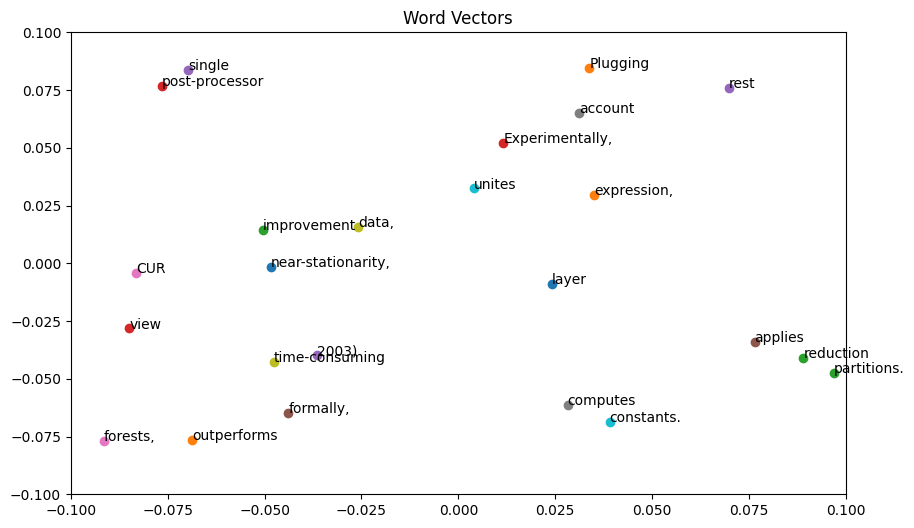

In [ ]:
# Visualization
def plot_word_vectors(word_vectors, vocab):
    plt.figure(figsize=(10, 6))
    for word, idx in word_to_idx.items():
        if idx == len(word_vectors):
          break
        vec = word_vectors[idx]
        plt.scatter(vec[0], vec[1])
        plt.annotate(word, (vec[0], vec[1]))


    plt.xlim(-0.1, 0.1)
    plt.ylim(-0.1, 0.1)
    plt.title("Word Vectors")
    plt.show()

plot_word_vectors(word_vectors[:25], vocab)

In [ ]:
# Given a sentence of tokens, return the corresponding indices
def convert_token_to_indices(sentence, word_to_ix, word_vectors):
  indices = []
  for token in sentence:
    # Check if the token is in our vocabularly. If it is, get it's index.
    # If not, get the index for the unknown token.
    if token in word_to_ix:
      index = word_to_ix[token]
      index_vector = word_vectors[index]
    else:
      index_vector = None
    indices.append(index_vector)
  return indices


In [ ]:
# Show an example
example_sentence = text_x[1]
example_indices = convert_token_to_indices(example_sentence, word_to_idx,word_vectors)


print(f"Original sentence is: {example_sentence}")
print(f"Going from words to indices: {example_indices}")

Original sentence is:   Sensor-based degradation signals measure the accumulation of damage of an
engineering system using sensor technology. Degradation signals can be used to
estimate, for example, the distribution of the remaining life of partially
degraded systems and/or their components. In this paper we present a
nonparametric degradation modeling framework for making inference on the
evolution of degradation signals that are observed sparsely or over short
intervals of times. Furthermore, an empirical Bayes approach is used to update
the stochastic parameters of the degradation model in real-time using training
degradation signals for online monitoring of components operating in the field.
The primary application of this Bayesian framework is updating the residual
lifetime up to a degradation threshold of partially degraded components. We
validate our degradation modeling approach using a real-world crack growth data
set as well as a case study of simulated degradation signals.


In [ ]:
# Converting our sentences to indices
example_padded_indices = [convert_token_to_indices(s, word_to_idx,word_vectors) for s in train_x]
example_padded_indices_train_y = [convert_token_to_indices(s, word_to_idx,word_vectors) for s in train_y]
example_padded_indices_test = [convert_token_to_indices(s, word_to_idx,word_vectors) for s in text_x]

In [ ]:
example_string = [' '.join(map(str,seq)) for seq in example_padded_indices]
Vectorizer = CountVectorizer()
x = Vectorizer.fit_transform(example_string)

In [ ]:
example_string = [' '.join(map(str,seq)) for seq in example_padded_indices_train_y]
Vectorizer = CountVectorizer()
y = Vectorizer.fit_transform(example_string)

In [ ]:
example_string = [' '.join(map(str,seq)) for seq in example_padded_indices_test]
Vectorizer = CountVectorizer()
x_test = Vectorizer.fit_transform(example_string)

In [ ]:
x

<64x1106 sparse matrix of type '<class 'numpy.int64'>'
	with 33416 stored elements in Compressed Sparse Row format>

In [ ]:
y

<64x201 sparse matrix of type '<class 'numpy.int64'>'
	with 6064 stored elements in Compressed Sparse Row format>

In [ ]:
x_test

<3936x1106 sparse matrix of type '<class 'numpy.int64'>'
	with 1972121 stored elements in Compressed Sparse Row format>

In [ ]:
Y = y.toarray()  # Convert Y to a dense array
X = x.toarray()  # Convert X to a dense array
X_test = x_test.toarray()

model_1 = LinearRegression()
model_1.fit(X, Y)

model_2 = xgb.XGBRegressor()
model_2.fit(X, Y)

model_3 = RandomForestRegressor()
model_3.fit(X, Y)

pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)

pred_final = (pred_1+pred_2+pred_3)/3.0

predictions = np.where(pred_final > 0.5, 1, 0)
predictions = [pred[0] for pred in predictions]
predictions

[1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,


In [ ]:
data = {'prediction': predictions}
df = pd.DataFrame(data)
df = df.replace({1: 'ML', 0: 'Applied'})
print(df)

     prediction
0            ML
1            ML
2            ML
3       Applied
4       Applied
...         ...
3931         ML
3932         ML
3933    Applied
3934         ML
3935    Applied

[3936 rows x 1 columns]


**Sparse Matrix** & **dense matrix**

A `sparse matrix` is a matrix that is comprised of mostly zero values.
Sparse matrices are distinct from matrices with mostly non-zero values, which are referred to as dense matrices.
Sparse matrices can cause problems with regards to space and time complexity.

A `dense matrix` or array is a data structure that stores every element of a matrix or array, including zero elements. In other words, a dense matrix/array does not have any missing or "sparse" entries. It is the opposite of a sparse matrix/array, where only the non-zero elements are stored explicitly.

Both todense() and toarray() methods convert the sparse matrix to a dense matrix/array by filling in the missing values with zeros, resulting in a matrix/array of the same shape as the original sparse matrix.

####Popular Pre-trained CBOW Embeddings




*  **Word2Vec:** Word2Vec is one of the most well-known pre-trained CBOW models. Developed by `Google`, Word2Vec generates word embeddings by training CBOW and Skip-gram models on vast text corpora. Word2Vec embeddings have been widely used in various NLP applications and are available in different dimensions (e.g., 50, 100, 300) to suit different requirements.


*   **GloVe:** `Global Vectors for Word Representation (GloVe)` is another popular pre-trained word embedding technique. Unlike Word2Vec, GloVe combines global word co-occurrence statistics to learn word embeddings. GloVe embeddings are available in various dimensions and are known for their efficiency and ability to capture global context.


*   **FastText:** FastText is an extension of Word2Vec that considers subword information. It generates word embeddings by averaging subword embeddings, which helps handle morphologically rich languages and OOV words more effectively.




#####word2vec

In [ ]:
model = api.load("word2vec-google-news-300")  # download the model and return as object ready for use

In [ ]:
words = " ".join(sentense).split()
vocab = list(set(words))

word_vectors = {}
for word in vocab:
  try:
    word_vectors[word] = model[word]
  except:
    word_vectors[word] = None

In [ ]:
# Given a sentence of tokens, return the corresponding indices
def convert_token_to_indices(sentence, word_vectors):
  indices = []
  for token in sentence:
    # Check if the token is in our vocabularly. If it is, get it's index.
    # If not, get the index for the unknown token.
    if token in word_vectors:
      index_vector = word_vectors[token]
    else:
      index_vector = None
    indices.append(index_vector)
  return indices

In [ ]:
# Show an example
example_sentence = train_x[1]
example_indices = convert_token_to_indices(example_sentence, word_vectors)

print(f"Original sentence is: {example_sentence}")
print(f"Going from words to indices: {example_indices}")

In [ ]:
# Converting our sentences to indices
example_padded_indices = [convert_token_to_indices(s,word_vectors) for s in train_x]
example_padded_indices_train_y = [convert_token_to_indices(s,word_vectors) for s in train_y]
example_padded_indices_test = [convert_token_to_indices(s,word_vectors) for s in text_x]

In [ ]:
example_string = [' '.join(map(str,seq)) for seq in example_padded_indices]
Vectorizer = CountVectorizer()
x = Vectorizer.fit_transform(example_string)

In [ ]:
example_string = [' '.join(map(str,seq)) for seq in example_padded_indices_train_y]
Vectorizer = CountVectorizer()
y = Vectorizer.fit_transform(example_string)

In [ ]:
example_string = [' '.join(map(str,seq)) for seq in example_padded_indices_test]
Vectorizer = CountVectorizer()
x_test = Vectorizer.fit_transform(example_string)

In [ ]:
x

<64x1113 sparse matrix of type '<class 'numpy.int64'>'
	with 45010 stored elements in Compressed Sparse Row format>

In [ ]:
y

<64x351 sparse matrix of type '<class 'numpy.int64'>'
	with 10564 stored elements in Compressed Sparse Row format>

In [ ]:
x_test

<3936x1113 sparse matrix of type '<class 'numpy.int64'>'
	with 2709717 stored elements in Compressed Sparse Row format>

In [ ]:
Y = y.toarray()  # Convert Y to a dense array
X = x.toarray()  # Convert X to a dense array
X_test = x_test.toarray()

model_1 = LinearRegression()
model_1.fit(X, Y)

model_2 = xgb.XGBRegressor()
model_2.fit(X, Y)

model_3 = RandomForestRegressor()
model_3.fit(X, Y)

pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)

pred_final = (pred_1+pred_2+pred_3)/3.0

predictions = np.where(pred_final > 0.5, 1, 0)
predictions = [pred[0] for pred in predictions]
predictions

[1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,


In [ ]:
data = {'prediction': predictions}
df = pd.DataFrame(data)
df = df.replace({1: 'ML', 0: 'Applied'})
print(df)

     prediction
0            ML
1       Applied
2            ML
3       Applied
4            ML
...         ...
3931         ML
3932         ML
3933         ML
3934         ML
3935    Applied

[3936 rows x 1 columns]


In [ ]:
df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Hakaton-LLM/Ensemble/output.csv', index=False)

#####GloVe

Global Vectors for Word Representation, or GloVe, is an “unsupervised learning algorithm for obtaining vector representations for words.” Simply put, GloVe allows us to take a corpus of text, and intuitively transform each word in that corpus into a position in a high-dimensional space. This means that similar words will be placed together.

GloVe is trained on global word co-occurrence statistics. It leverages the global context to create word embeddings that reflect the overall meaning of words based on their co-occurrence probabilities. this method, we take the corpus and iterate through it and get the co-occurrence of each word with other words in the corpus. We get a co-occurrence matrix through this. The words which occur next to each other get a value of 1, if they are one word apart then 1/2, if two words apart then 1/3 and so on.

Let us take an example to understand how the matrix is created. We have a small corpus:


Corpus:
It is a nice evening.
Good Evening!
Is it a nice evening?

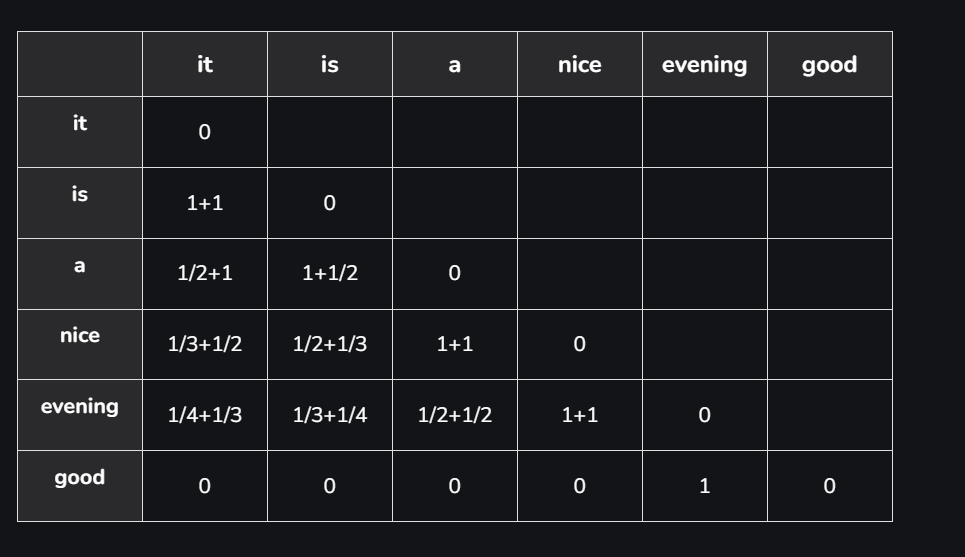

The upper half of the matrix will be a reflection of the lower half. We can consider a window frame as well to calculate the co-occurrences by shifting the frame till the end of the corpus. This helps gather information about the context in which the word is used.

Initially, the vectors for each word is assigned randomly. Then we take two pairs of vectors and see how close they are to each other in space. If they occur together more often or have a higher value in the co-occurrence matrix and are far apart in space then they are brought close to each other. If they are close to each other but are rarely or not frequently used together then they are moved further apart in space.

After many iterations of the above process, we’ll get a vector space representation that approximates the information from the co-occurrence matrix. The performance of GloVe is better than Word2Vec in terms of both semantic and syntactic capturing.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2024-03-01 07:36:58--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-03-01 07:36:59--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-03-01 07:36:59--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
# create the dict.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentense)

# number of unique words in dict.
print("Number of unique words in dictionary=",
	len(tokenizer.word_index))
print("Dictionary is = ", tokenizer.word_index)

# download glove and unzip it in Notebook.
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove*.zip

# vocab: 'the': 1, mapping of words with
# integers in seq. 1,2,3..
# embedding: 1->dense vector
def embedding_for_vocab(filepath, word_index,
						embedding_dim):
	vocab_size = len(word_index) + 1

	# Adding again 1 because of reserved 0 index
	embedding_matrix_vocab = np.zeros((vocab_size,
									embedding_dim))

	with open(filepath, encoding="utf8") as f:
		for line in f:
			word, *vector = line.split()
			if word in word_index:
				idx = word_index[word]
				embedding_matrix_vocab[idx] = np.array(
					vector, dtype=np.float32)[:embedding_dim]

	return embedding_matrix_vocab


# matrix for vocab: word_index
embedding_dim = 50
embedding_matrix_vocab = embedding_for_vocab(
	'/content/glove.6B.50d.txt', tokenizer.word_index,
embedding_dim)

print("Dense vector for first word is => ",
	embedding_matrix_vocab[1])


Number of unique words in dictionary= 2401
Dictionary is =  {'the': 1, 'of': 2, 'and': 3, 'a': 4, 'to': 5, 'in': 6, 'we': 7, 'is': 8, 'for': 9, 'that': 10, 'are': 11, 'on': 12, 'model': 13, 'this': 14, 'data': 15, 'with': 16, 'as': 17, 'which': 18, 'an': 19, 'models': 20, 'by': 21, 'our': 22, 'from': 23, 'it': 24, 'class': 25, 'at': 26, 'approach': 27, 'using': 28, 'sparse': 29, 'be': 30, 'learning': 31, 'problem': 32, 'method': 33, 'show': 34, 'used': 35, 'these': 36, 'time': 37, 'or': 38, 'methods': 39, 'two': 40, 'bayesian': 41, 'inference': 42, 'has': 43, 'paper': 44, 'results': 45, 'random': 46, 'both': 47, 'between': 48, 'can': 49, 'new': 50, 'not': 51, 'each': 52, 'algorithm': 53, 'analysis': 54, 'different': 55, 'set': 56, 'but': 57, 'i': 58, 'when': 59, 'over': 60, 'distribution': 61, 'linear': 62, 'based': 63, 'applied': 64, 'estimation': 65, 'markov': 66, 'number': 67, 'probability': 68, 'well': 69, 'selection': 70, 'have': 71, 'propose': 72, 'ml': 73, 'one': 74, 'statistica

In [ ]:
len(tokenizer.word_index)

2401

In [ ]:
# Given a sentence of tokens, return the corresponding indices
def convert_token_to_indices(sentence, embedding_matrix_vocab):
  indices = []
  for token in sentence:
    # Check if the token is in our vocabularly. If it is, get it's index.
    # If not, get the index for the unknown token.
    if token in tokenizer.word_index:
      index = tokenizer.word_index[token]
      index_vector = embedding_matrix_vocab[index]
    else:
      index_vector = None
    indices.append(index_vector)
  return indices

In [ ]:
# Show an example
example_sentence = train_x[1]
example_indices = convert_token_to_indices(example_sentence, embedding_matrix_vocab)

print(f"Original sentence is: {example_sentence}")
print(f"Going from words to indices: {example_indices}")

Original sentence is: propose novel approach density estimation exponential families case true density may fall within chosen family approach augments sufficient statistics features designed accumulate probability mass neighborhood observed points resulting non parametric model similar kernel density estimators show mild conditions resulting model uses sufficient statistics density within chosen exponential family asymptotically approximates densities outside chosen exponential family using proposed approach modify exponential random graph model commonly used modeling small size graph distributions address well known issue model degeneracy 
Going from words to indices: [array([-3.55589986e-01,  1.23860002e+00,  1.43480003e+00,  1.04470003e+00,
        1.03349996e+00,  1.04450002e-01,  2.77599990e-01, -1.26750004e+00,
       -9.57880020e-01, -5.96029997e-01, -1.82799995e-01, -1.82470009e-02,
       -9.35530007e-01, -4.97060001e-01,  8.58450029e-03,  8.69710028e-01,
       -3.52499992e-0

In [ ]:
# Converting our sentences to indices
example_padded_indices = [convert_token_to_indices(s,embedding_matrix_vocab) for s in train_x]
example_padded_indices_train_y = [convert_token_to_indices(s,embedding_matrix_vocab) for s in train_y]
example_padded_indices_test = [convert_token_to_indices(s,embedding_matrix_vocab) for s in text_x]

In [ ]:
example_string = [' '.join(map(str,seq)) for seq in example_padded_indices]
Vectorizer = CountVectorizer()
x = Vectorizer.fit_transform(example_string)

In [ ]:
example_string = [' '.join(map(str,seq)) for seq in example_padded_indices_train_y]
Vectorizer = CountVectorizer()
y = Vectorizer.fit_transform(example_string)

In [ ]:
example_string = [' '.join(map(str,seq)) for seq in example_padded_indices_test]
Vectorizer = CountVectorizer()
x_test = Vectorizer.fit_transform(example_string)

In [ ]:
x

<64x1301 sparse matrix of type '<class 'numpy.int64'>'
	with 60069 stored elements in Compressed Sparse Row format>

In [ ]:
y

<64x207 sparse matrix of type '<class 'numpy.int64'>'
	with 6244 stored elements in Compressed Sparse Row format>

In [ ]:
x_test

<3936x1301 sparse matrix of type '<class 'numpy.int64'>'
	with 3580586 stored elements in Compressed Sparse Row format>

In [ ]:
Y = y.toarray()  # Convert Y to a dense array
X = x.toarray()  # Convert X to a dense array
X_test = x_test.toarray()

model_1 = LinearRegression()
model_1.fit(X, Y)

model_2 = xgb.XGBRegressor()
model_2.fit(X, Y)

model_3 = RandomForestRegressor()
model_3.fit(X, Y)

RandomForestRegressor()

In [ ]:
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)

pred_final = (pred_1+pred_2+pred_3)/3.0

predictions = np.where(pred_final > 0.5, 1, 0)
predictions = [pred[0] for pred in predictions]
predictions

[1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [ ]:
data = {'prediction': predictions}
df = pd.DataFrame(data)
df = df.replace({1: 'ML', 0: 'Applied'})
print(df)

     prediction
0            ML
1            ML
2            ML
3       Applied
4            ML
...         ...
3931    Applied
3932         ML
3933    Applied
3934         ML
3935         ML

[3936 rows x 1 columns]


In [ ]:
df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Hakaton-LLM/Ensemble/output.csv', index=False)

###FastText

FastText is an open-source library, developed by the `Facebook AI` Research lab. Its main focus is on achieving scalable solutions for the tasks of text classification and representation while processing large datasets quickly and accurately.

To improve vector representation for `morphologically` rich language, FastText provides embeddings for character n-grams, representing words as the average of these embeddings. It is an extension of the word2vec model. Word2Vec model provides embedding to the words, whereas FastText provides embeddings to the character n-grams. Like the word2vec model, FastText uses CBOW and Skip-gram to compute the vectors.

FastText can also handle `out-of-vocabulary` words, i.e., the fast text can find the word embeddings that are not present at the time of training.

`Out-of-vocabulary (OOV)` words are words that do not occur while training the data and are not present in the model’s vocabulary. Word embedding models like word2vec or GloVe cannot provide embeddings for the OOV words because they provide embeddings for words; hence, if a new word occurs, it cannot provide embedding.

Since FastText provides embeddings for character n-grams, it can provide embeddings for OOV words. If an OOV word occurs, then fastText provides embedding for that word by embedding its character n-gram.

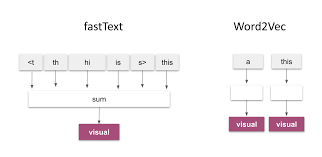

In [ ]:
word_tokenizer = nltk.WordPunctTokenizer()
word_tokens = [word_tokenizer.tokenize(sent) for sent in tqdm(clean_corpus)]
word_tokens

100%|██████████| 64/64 [00:00<00:00, 6207.32it/s]


[['last',
  'four',
  'year',
  'daily',
  'deal',
  'emerged',
  'nowhere',
  'become',
  'multi',
  'billion',
  'dollar',
  'industry',
  'world',
  'wide',
  'daily',
  'deal',
  'site',
  'groupon',
  'livingsocial',
  'offer',
  'product',
  'service',
  'deep',
  'discount',
  'consumer',
  'via',
  'email',
  'social',
  'network',
  'industry',
  'matures',
  'many',
  'question',
  'regarding',
  'impact',
  'daily',
  'deal',
  'marketplace',
  'important',
  'question',
  'regard',
  'concern',
  'reason',
  'business',
  'decide',
  'offer',
  'daily',
  'deal',
  'longer',
  'term',
  'impact',
  'business',
  'present',
  'paper',
  'investigate',
  'whether',
  'unobserved',
  'factor',
  'make',
  'marketer',
  'run',
  'daily',
  'deal',
  'correlated',
  'unobserved',
  'factor',
  'influence',
  'business',
  'particular',
  'employ',
  'framework',
  'seemingly',
  'unrelated',
  'regression',
  'model',
  'correlation',
  'error',
  'predicting',
  'whether',
  'b

In [ ]:
# Defining values for parameters
embedding_size = 100
window_size = 5
min_word = 5
down_sampling = 1e-2

fast_Text_model = FastText(word_tokens,
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      workers = 4,
                      sg=1)

In [ ]:
# Check word embedding for a perticular word
fast_Text_model.wv['blue']

array([-0.13068298,  0.09355544, -0.01367463,  0.01037386,  0.09704065,
       -0.02624224,  0.06978812,  0.17864957,  0.08832209,  0.01413272,
        0.08587287, -0.01911334, -0.0289911 , -0.08260334, -0.00107167,
       -0.22719109,  0.05550719, -0.11309476, -0.00115753, -0.07430395,
       -0.01695127,  0.0442378 ,  0.13773482, -0.07413466,  0.08605412,
       -0.09728436, -0.19704778, -0.029233  , -0.02854923, -0.00178149,
        0.11151715, -0.01872488,  0.11556916, -0.06755353, -0.05088762,
       -0.09121989,  0.1667517 ,  0.18967655, -0.07500609,  0.09967277,
        0.07786584, -0.16866812, -0.03253803, -0.09191096,  0.13280812,
       -0.0534202 , -0.0748143 , -0.06704451, -0.01124469, -0.02374503,
        0.08213467,  0.07507145, -0.09151985, -0.08213796,  0.03178224,
       -0.0688537 , -0.0521281 , -0.04196984,  0.02939517,  0.10510232,
        0.05643154, -0.13936445, -0.07229161, -0.12627468, -0.07851936,
        0.08770301,  0.02841568,  0.09577212,  0.07894818,  0.16

In [ ]:
# Dimention must be 100
fast_Text_model.wv['chicken'].shape

(100,)

**tokenization**

In order to use textual data for predictive modeling, the text must be parsed to remove certain words – this process is called tokenization.

In [ ]:
# create the dict.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentense)

# number of unique words in dict.
print("Number of unique words in dictionary=",
	len(tokenizer.word_index))
print("Dictionary is = ", tokenizer.word_index)

Number of unique words in dictionary= 2401
Dictionary is =  {'the': 1, 'of': 2, 'and': 3, 'a': 4, 'to': 5, 'in': 6, 'we': 7, 'is': 8, 'for': 9, 'that': 10, 'are': 11, 'on': 12, 'model': 13, 'this': 14, 'data': 15, 'with': 16, 'as': 17, 'which': 18, 'an': 19, 'models': 20, 'by': 21, 'our': 22, 'from': 23, 'it': 24, 'class': 25, 'at': 26, 'approach': 27, 'using': 28, 'sparse': 29, 'be': 30, 'learning': 31, 'problem': 32, 'method': 33, 'show': 34, 'used': 35, 'these': 36, 'time': 37, 'or': 38, 'methods': 39, 'two': 40, 'bayesian': 41, 'inference': 42, 'has': 43, 'paper': 44, 'results': 45, 'random': 46, 'both': 47, 'between': 48, 'can': 49, 'new': 50, 'not': 51, 'each': 52, 'algorithm': 53, 'analysis': 54, 'different': 55, 'set': 56, 'but': 57, 'i': 58, 'when': 59, 'over': 60, 'distribution': 61, 'linear': 62, 'based': 63, 'applied': 64, 'estimation': 65, 'markov': 66, 'number': 67, 'probability': 68, 'well': 69, 'selection': 70, 'have': 71, 'propose': 72, 'ml': 73, 'one': 74, 'statistica

In [ ]:
def embedding_for_vocab(word_index,
						embedding_dim):
	vocab_size = len(word_index) + 1

	# Adding again 1 because of reserved 0 index
	embedding_matrix_vocab = np.zeros((vocab_size,
									embedding_dim))
	for word in word_index:
				idx = word_index[word]
				embedding_matrix_vocab[idx] = np.array(
					 fast_Text_model.wv[word], dtype=np.float32)[:embedding_dim]

	return embedding_matrix_vocab


# matrix for vocab: word_index
embedding_dim = 100
embedding_matrix_vocab = embedding_for_vocab(
tokenizer.word_index,
embedding_dim)

print("Dense vector for first word is => ",
	embedding_matrix_vocab[1])

Dense vector for first word is =>  [-0.25934702  0.19632648 -0.02584348  0.01208116  0.19548266 -0.06054185
  0.14568873  0.36653545  0.17883523  0.03094568  0.17531087 -0.03965858
 -0.05107261 -0.17125954 -0.00475577 -0.45403647  0.10924152 -0.23081391
 -0.01088974 -0.14954956 -0.03677508  0.09034412  0.27794227 -0.14594619
  0.17595357 -0.20326972 -0.39156684 -0.06962159 -0.06098585 -0.00890274
  0.21984608 -0.04143314  0.2292829  -0.14298634 -0.10799286 -0.18267687
  0.33552423  0.38278249 -0.14454785  0.19908379  0.16032346 -0.33553267
 -0.06953277 -0.19088642  0.27308491 -0.10388257 -0.14627656 -0.13006639
 -0.01801076 -0.05195632  0.16402318  0.1609239  -0.18193686 -0.17225762
  0.06726334 -0.13855964 -0.10312621 -0.08345256  0.0577064   0.21280634
  0.11351299 -0.28384766 -0.15095295 -0.25737005 -0.16012572  0.17765462
  0.06161743  0.19426768  0.165077    0.33204666 -0.07514272  0.31136003
  0.06801921 -0.24347638  0.09322324  0.14388399  0.3615047   0.15738596
 -0.18341219 -0.

In [ ]:
# Given a sentence of tokens, return the corresponding indices
def convert_token_to_indices(sentence, embedding_matrix_vocab):
  indices = []
  for token in sentence:
    # Check if the token is in our vocabularly. If it is, get it's index.
    # If not, get the index for the unknown token.
    if token in tokenizer.word_index:
      index = tokenizer.word_index[token]
      index_vector = embedding_matrix_vocab[index]
    else:
      index_vector = None
    indices.append(index_vector)
  return indices

In [ ]:
# Show an example
example_sentence = train_x[1]
example_indices = convert_token_to_indices(example_sentence, embedding_matrix_vocab)

print(f"Original sentence is: {example_sentence}")
print(f"Going from words to indices: {example_indices}")

Streaming output truncated to the last 5000 lines.
       -1.75439240e-03, -9.17646289e-03,  1.14634039e-03, -7.14131957e-03,
        3.70718469e-03,  9.93035641e-03,  8.13985243e-03, -7.89476279e-03,
       -9.08262469e-03,  7.31638912e-03,  2.24396121e-03, -2.27668532e-03,
       -4.83798976e-05, -1.87061669e-03,  9.21914820e-03,  6.05031266e-04,
        9.22578294e-03,  5.74501744e-03, -9.37231164e-03,  1.59393786e-03,
       -4.51067230e-03, -9.59740893e-04,  1.10245706e-03,  1.30754709e-03,
        8.67998973e-03,  9.88193974e-03,  1.81202893e-04,  1.67644618e-03,
       -5.39098959e-03, -8.79913289e-03, -9.92705207e-03, -3.03599838e-04,
       -4.10619006e-03,  5.34528261e-03, -3.24949389e-03, -4.59032785e-03,
       -9.30776820e-03, -9.64846089e-03,  5.50816068e-03,  8.04955955e-04,
       -1.50840043e-03, -5.67810284e-03, -2.05296511e-03,  1.27724884e-03,
        2.52921111e-03,  2.94744503e-03,  1.87290786e-03, -9.07665119e-03,
        1.10073085e-03,  8.10956862e-03, -6.67540

In [ ]:
# Converting our sentences to indices
example_padded_indices = [convert_token_to_indices(s,embedding_matrix_vocab) for s in train_x]
example_padded_indices_train_y = [convert_token_to_indices(s,embedding_matrix_vocab) for s in train_y]
example_padded_indices_test = [convert_token_to_indices(s,embedding_matrix_vocab) for s in text_x]

In [ ]:
len(example_padded_indices)

64

In [ ]:
len(example_padded_indices_train_y)

64

In [ ]:
len(example_padded_indices_test)

3936

**vectorization**

 These words need to then be encoded as integers, or floating-point values, for use as inputs in machine learning algorithms. This process is called feature extraction (or vectorization).

In [ ]:
example_string = [' '.join(map(str,seq)) for seq in example_padded_indices]
Vctorizer = CountVectorizer()
x = Vectorizer.fit_transform(example_string)

In [ ]:
x.shape

(64, 2602)

In [ ]:
example_string = [' '.join(map(str,seq)) for seq in example_padded_indices_train_y]
Vectorizer = CountVectorizer()
y = Vectorizer.fit_transform(example_string)

In [ ]:
example_string = [' '.join(map(str,seq)) for seq in example_padded_indices_test]
Vectorizer = CountVectorizer()
x_test = Vectorizer.fit_transform(example_string)

In [ ]:
len(example_string)

3936

In [ ]:
type(example_string)

list

In [ ]:
type(example_string[0])

str

In [ ]:
len(example_string[0].split())

48576

In [ ]:
len(example_string[1].split())

In [ ]:
x_test.shape

(3936, 2602)

In [ ]:
x_test[0].shape

(1, 2602)

In [ ]:
x

<64x2602 sparse matrix of type '<class 'numpy.int64'>'
	with 119805 stored elements in Compressed Sparse Row format>

In [ ]:
y

<64x405 sparse matrix of type '<class 'numpy.int64'>'
	with 12184 stored elements in Compressed Sparse Row format>

In [ ]:
x_test

<3936x2602 sparse matrix of type '<class 'numpy.int64'>'
	with 7138532 stored elements in Compressed Sparse Row format>

The dimensions (3936, 2602) in `x_test` indicate that the input matrix for the model has 3936 samples and 2602 features. In this case, the samples are in the rows and the features are in the columns.

In this example, `example_padded_indices_test`, which is a list of numerical sequences, is first converted to `example_string`. This conversion involves transforming each numerical sequence into a string and separating its elements using a space delimiter.

Then, the `CountVectorizer` is used to transform the strings into feature vectors. Here, each feature is determined by the count of its occurrences in the string. The values of the feature vectors for each sample are stored in `x_test`.

The number of columns in `x_test` is 2602, indicating that there are 2602 unique features identified using the `CountVectorizer` across the entire dataset. This number of features could correspond to the number of different words or phrases in the data, for example, if each feature corresponds to a specific word.

Therefore, the dimensions (3936, 2602) in `x_test` indicate that we have 3936 samples with 2602 features that can be used as input for the model.

When you change the length of the word embeddings from 100 to 50, the number of features decreases. If you initially had 100 features (based on the word embedding length of 100) and you change the length of the word embeddings to 50, each word is now represented by 50 features. Therefore, the number of features is halved.

In the previous example, the number of features was 2602 because each word was represented by 100 features. But with a reduction in the word embedding length to 50, each word is now represented by 50 features, resulting in the total number of features being halved to 1301.

Using the CountVectorizer library from scikit-learn, features are automatically extracted and transformed. By default, this library performs the following operations:

It divides all input sentences or texts into smaller pieces called tokens. It uses a specific tokenizer algorithm (e.g., whitespace) for the division.

Then, it calculates the count of each token in each sample. This step is done using a counter.

Finally, it converts all tokens into a feature vector. This feature vector represents the count of each token in each sample.

Therefore, it only considers the number of different tokens in each sample, not the total number of features in the entire dataset. In other words, the number of features in each sample is equal to the number of different tokens in that sample.

So, if the first sentence has 48,576 features and the second sentence has 59,746 features, it is likely that the number of different tokens in each sentence is 2,602, which is why the output dimensions are also 2,602. This may be due to the presence of duplicate tokens in the input sentences or text, which are counted only once during the counting step.

In [ ]:
Y = y.toarray()  # Convert Y to a dense array
X = x.toarray()  # Convert X to a dense array
X_test = x_test.toarray()

model_1 = LinearRegression()
model_1.fit(X, Y)

model_2 = xgb.XGBRegressor()
model_2.fit(X, Y)

model_3 = RandomForestRegressor()
model_3.fit(X, Y)

In [ ]:
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)

pred_final = (pred_1+pred_2+pred_3)/3.0

predictions = np.where(pred_final > 0.5, 1, 0)
predictions = [pred[0] for pred in predictions]
predictions

In [ ]:
data = {'prediction': predictions}
df = pd.DataFrame(data)
df = df.replace({1: 'ML', 0: 'Applied'})
print(df)

###Skip-Gram

The Skip-Gram model learns distributed representations of words in a continuous vector space. The main objective of Skip-Gram is to predict context words (words surrounding a target word) given a target word. This is the opposite of the Continuous Bag of Words (CBOW) model, where the objective is to predict the target word based on its context. It is shown that this method produces more meaningful embeddings.

After applying the above neural embedding methods we get trained vectors of each word after many iterations through the corpus. These trained vectors preserve syntactical or semantic information and are converted to lower dimensions. The vectors with similar meaning or semantic information are placed close to each other in space.

The skip-gram neural network is composed of a single hidden layer. The input is a Bag of Words (BOW) with a value of 1 at the position of the centre word. The output is the probability of finding a specific word at each position in the context window. In the following example, we assume we’re using a window size of 1. As we can see, initially, the model predicts that the word shimmered follows the word wide in a sentence and that the word road precedes the word wide in a sentence.

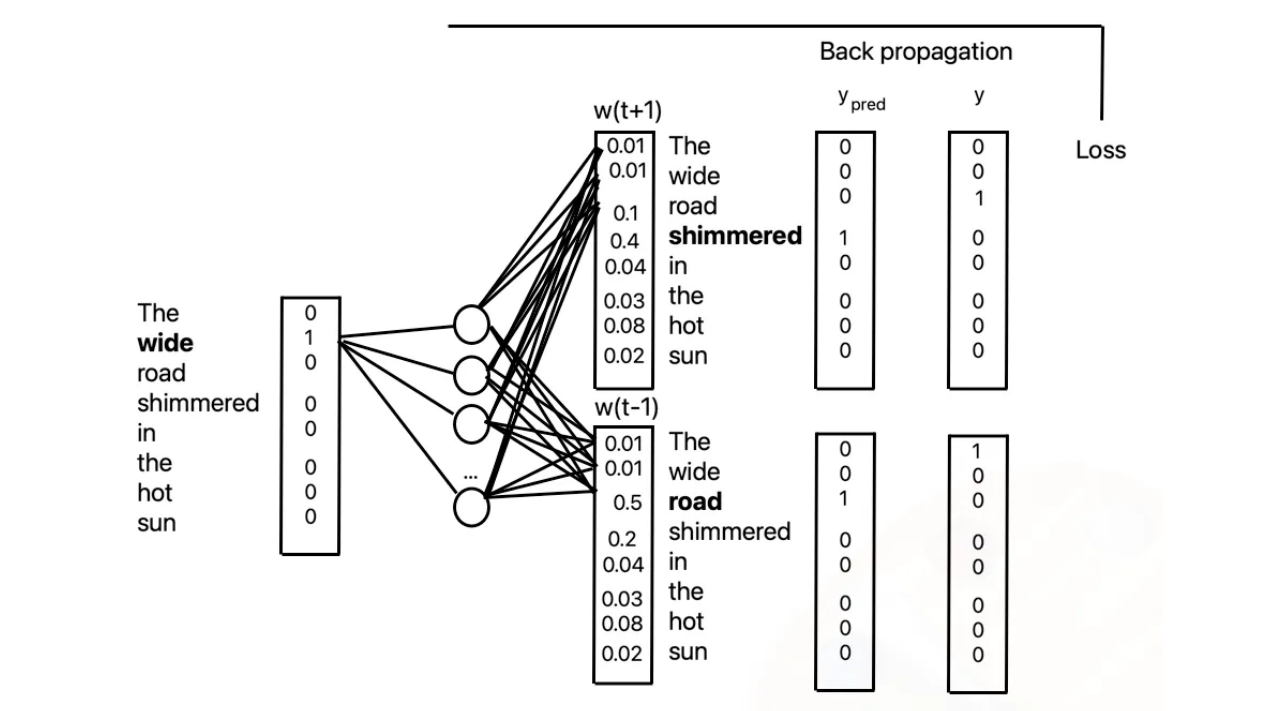

It’s important to note that we didn’t lowercase the words. Thus, we have The and the. However, in practice, you would.

Using back propagation, the model adjusts the weights until the error is minimized. As we can see, after a few iterations, it correctly predicts that the subsequent word after wide is road.

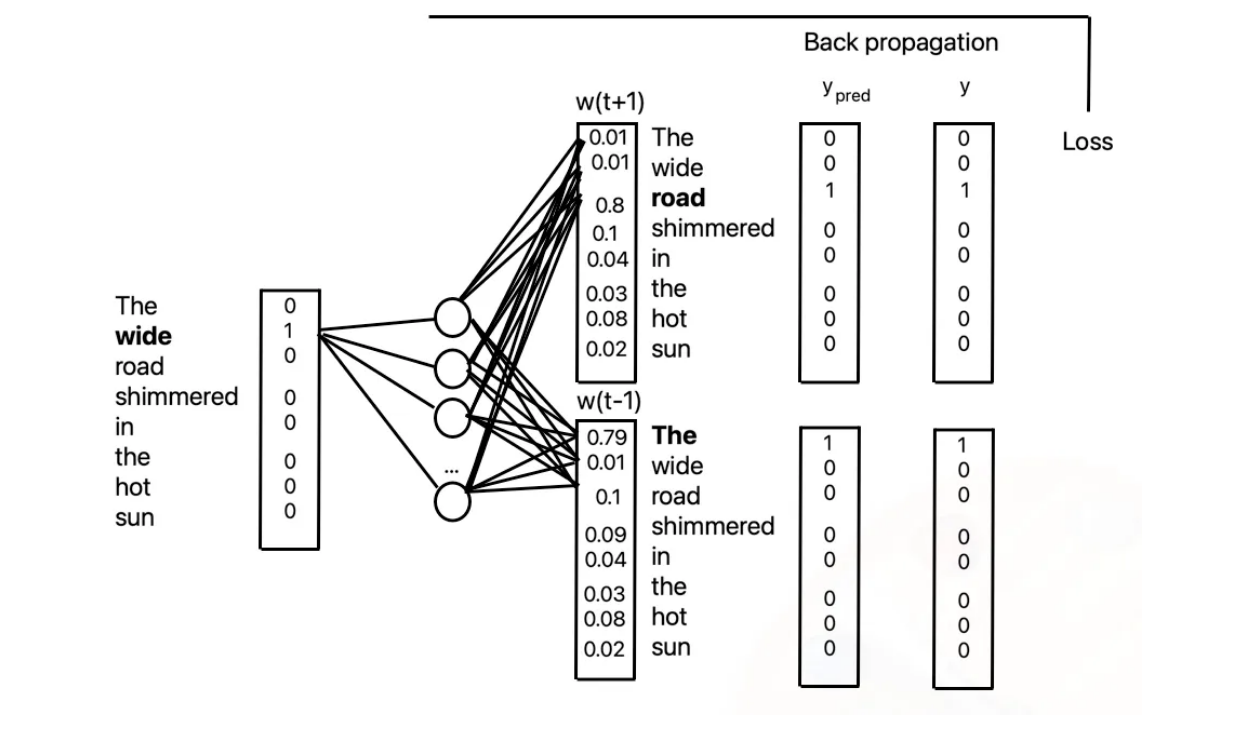

In [ ]:
word_tokenizer = nltk.WordPunctTokenizer()
word_tokens = [word_tokenizer.tokenize(sent) for sent in tqdm(clean_corpus)]
word_tokens



100%|██████████| 64/64 [00:00<00:00, 5681.29it/s]


[['last',
  'four',
  'year',
  'daily',
  'deal',
  'emerged',
  'nowhere',
  'become',
  'multi',
  'billion',
  'dollar',
  'industry',
  'world',
  'wide',
  'daily',
  'deal',
  'site',
  'groupon',
  'livingsocial',
  'offer',
  'product',
  'service',
  'deep',
  'discount',
  'consumer',
  'via',
  'email',
  'social',
  'network',
  'industry',
  'matures',
  'many',
  'question',
  'regarding',
  'impact',
  'daily',
  'deal',
  'marketplace',
  'important',
  'question',
  'regard',
  'concern',
  'reason',
  'business',
  'decide',
  'offer',
  'daily',
  'deal',
  'longer',
  'term',
  'impact',
  'business',
  'present',
  'paper',
  'investigate',
  'whether',
  'unobserved',
  'factor',
  'make',
  'marketer',
  'run',
  'daily',
  'deal',
  'correlated',
  'unobserved',
  'factor',
  'influence',
  'business',
  'particular',
  'employ',
  'framework',
  'seemingly',
  'unrelated',
  'regression',
  'model',
  'correlation',
  'error',
  'predicting',
  'whether',
  'b

In [ ]:
skipgram_model = Word2Vec(word_tokens,
                          vector_size=100,  # Dimensionality of the word vectors
                          window=5,         # Maximum distance between the current and predicted word within a sentence
                          sg=1,             # Skip-Gram model (1 for Skip-Gram, 0 for CBOW)
                          min_count=1,      # Ignores all words with a total frequency lower than this
                          workers=4)        # Number of CPU cores to use for training the model

In [ ]:
# Training
skipgram_model.train(word_tokens, total_examples=1, epochs=10)
skipgram_model.save("skipgram_model.model")
loaded_model = Word2Vec.load("skipgram_model.model")
vector_representation = loaded_model.wv['word']
print("Vector representation of 'word':", vector_representation)

Vector representation of 'word': [-0.00629911  0.13177614 -0.02628316  0.06808235  0.03985137 -0.24430548
  0.10450804  0.3001646  -0.10144144 -0.08787297 -0.03126729 -0.27726698
 -0.09095941 -0.06333304 -0.01867569 -0.15462829  0.05533341 -0.08637919
  0.10268529 -0.3381811   0.24231277  0.01772846  0.00646473  0.07575136
 -0.07964759 -0.11697549 -0.12339117 -0.20958188 -0.14598456  0.03735769
  0.22863156  0.08905347  0.01320164 -0.13288823 -0.01422935  0.082536
 -0.04005414 -0.16780451 -0.10412234 -0.41709706 -0.08678074 -0.24062963
 -0.01087944  0.00996454  0.11885875 -0.0596605  -0.16956091  0.00810623
  0.09798647  0.11783598 -0.00352028 -0.18930303 -0.14701532 -0.01583655
 -0.15510124  0.08589723  0.13944651 -0.02255062 -0.24465539  0.13521807
 -0.04342307  0.08264854  0.03639236 -0.04476603 -0.21412307  0.12975988
 -0.00495466  0.02466665 -0.06354898  0.09620017 -0.04456187  0.12514302
  0.14404936 -0.07721739  0.18337491  0.08841389  0.13850698 -0.00204705
 -0.2497206  -0.0272

In [ ]:
# Dimention must be 100
skipgram_model.wv['ml'].shape

(100,)

In [ ]:
# create the dict.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_corpus)

# number of unique words in dict.
print("Number of unique words in dictionary=",
	len(tokenizer.word_index))
print("Dictionary is = ", tokenizer.word_index)

Number of unique words in dictionary= 2069
Dictionary is =  {'model': 1, 'data': 2, 'method': 3, 'problem': 4, 'approach': 5, 'class': 6, 'distribution': 7, 'algorithm': 8, 'result': 9, 'show': 10, 'using': 11, 'sparse': 12, 'learning': 13, 'used': 14, 'time': 15, 'two': 16, 'inference': 17, 'set': 18, 'bayesian': 19, 'variable': 20, 'paper': 21, 'analysis': 22, 'feature': 23, 'random': 24, 'number': 25, 'network': 26, 'new': 27, 'probability': 28, 'state': 29, 'study': 30, 'different': 31, 'process': 32, 'linear': 33, 'based': 34, 'error': 35, 'applied': 36, 'estimation': 37, 'markov': 38, 'estimate': 39, 'well': 40, 'one': 41, 'selection': 42, 'present': 43, 'propose': 44, 'estimator': 45, 'ml': 46, 'statistical': 47, 'function': 48, 'efficient': 49, 'parameter': 50, 'likelihood': 51, 'classification': 52, 'block': 53, 'degree': 54, 'matrix': 55, 'proposed': 56, 'optimization': 57, 'also': 58, 'prior': 59, 'case': 60, 'within': 61, 'point': 62, 'known': 63, 'however': 64, 'technique'

In [ ]:
def embedding_for_vocab(word_index,
						embedding_dim):
	vocab_size = len(word_index) + 1

	# Adding again 1 because of reserved 0 index
	embedding_matrix_vocab = np.zeros((vocab_size,
									embedding_dim))
	for word in word_index:
				idx = word_index[word]
				embedding_matrix_vocab[idx] = np.array(
					 skipgram_model.wv[word], dtype=np.float32)[:embedding_dim]

	return embedding_matrix_vocab


# matrix for vocab: word_index
embedding_dim = 100
embedding_matrix_vocab = embedding_for_vocab(
tokenizer.word_index,
embedding_dim)

print("Dense vector for first word is => ",
	embedding_matrix_vocab[1])

Dense vector for first word is =>  [-0.19107661  0.02654272  0.20825082 -0.05254664  0.07099108 -0.40976137
  0.13818474  0.2725099  -0.0367048  -0.03223189  0.05684288 -0.24949253
  0.03953226  0.0423936   0.01523652 -0.11927237 -0.07762349 -0.21018827
 -0.00412414 -0.34884202  0.26774341  0.08997305  0.07869351 -0.02152995
 -0.14048101 -0.07803082 -0.08017712 -0.11680517 -0.15476209  0.13932206
  0.1902426   0.03030211  0.17091253 -0.12101296 -0.17437875  0.16548206
 -0.03644838 -0.28603345 -0.26475507 -0.26729277 -0.10308578 -0.19253378
 -0.09091867  0.13874646  0.19729482 -0.13355915 -0.30641904  0.08458516
  0.17189397 -0.00241982 -0.02389101 -0.05110822 -0.0714836  -0.07370924
 -0.13768667 -0.02248104  0.06896915  0.06132372 -0.16272996  0.2362192
 -0.09241597 -0.01224301 -0.03480635  0.01394132 -0.14293464  0.25655091
  0.08573064  0.12656441 -0.26868704  0.28216317 -0.33061162  0.11676075
  0.08115148 -0.11796791  0.17406346  0.15268369  0.06385566 -0.08799474
 -0.20161386  0.0

In [ ]:
# Given a sentence of tokens, return the corresponding indices
def convert_token_to_indices(sentence, embedding_matrix_vocab):
  indices = []
  for token in sentence:
    # Check if the token is in our vocabularly. If it is, get it's index.
    # If not, get the index for the unknown token.
    if token in tokenizer.word_index:
      index = tokenizer.word_index[token]
      index_vector = embedding_matrix_vocab[index]
    else:
      index_vector = None
    indices.append(index_vector)
  return indices

In [ ]:
# Show an example
example_sentence = train_x[1]
example_indices = convert_token_to_indices(example_sentence, embedding_matrix_vocab)

print(f"Original sentence is: {example_sentence}")
print(f"Going from words to indices: {example_indices}")

Original sentence is: propose novel approach density estimation exponential families case true density may fall within chosen family approach augments sufficient statistics features designed accumulate probability mass neighborhood observed points resulting non parametric model similar kernel density estimators show mild conditions resulting model uses sufficient statistics density within chosen exponential family asymptotically approximates densities outside chosen exponential family using proposed approach modify exponential random graph model commonly used modeling small size graph distributions address well known issue model degeneracy 
Going from words to indices: [array([-0.0733026 ,  0.01771027,  0.08637717, -0.03027016,  0.02630237,
       -0.17005993,  0.05242847,  0.10405234, -0.02032347, -0.00564949,
        0.01394787, -0.10308683,  0.01077865,  0.00454406,  0.00235984,
       -0.06263998, -0.03928277, -0.07993268, -0.00327267, -0.13465266,
        0.11433188,  0.03574938, 

In [ ]:
# Converting our sentences to indices
example_padded_indices = [convert_token_to_indices(s,embedding_matrix_vocab) for s in train_x]
example_padded_indices_train_y = [convert_token_to_indices(s,embedding_matrix_vocab) for s in train_y]
example_padded_indices_test = [convert_token_to_indices(s,embedding_matrix_vocab) for s in text_x]

  0%|          | 0/64 [10:22<?, ?it/s]


In [ ]:
len(example_padded_indices)

64

In [ ]:
len(example_padded_indices_train_y)

64

In [ ]:
len(example_padded_indices_test)

3936

In [ ]:
example_string = [' '.join(map(str,seq)) for seq in example_padded_indices]
Vectorizer = CountVectorizer()
x = Vectorizer.fit_transform(example_string)

In [ ]:
example_string = [' '.join(map(str,seq)) for seq in example_padded_indices_train_y]
Vectorizer = CountVectorizer()
y = Vectorizer.fit_transform(example_string)

In [ ]:
example_string = [' '.join(map(str,seq)) for seq in example_padded_indices_test]
Vectorizer = CountVectorizer()
x_test = Vectorizer.fit_transform(example_string)

In [ ]:
x

<64x1505 sparse matrix of type '<class 'numpy.int64'>'
	with 53536 stored elements in Compressed Sparse Row format>

In [ ]:
y

<64x201 sparse matrix of type '<class 'numpy.int64'>'
	with 6064 stored elements in Compressed Sparse Row format>

In [ ]:
x_test

<3936x1505 sparse matrix of type '<class 'numpy.int64'>'
	with 3126900 stored elements in Compressed Sparse Row format>

In [ ]:
Y = y.toarray()  # Convert Y to a dense array
X = x.toarray()  # Convert X to a dense array
X_test = x_test.toarray()

model_1 = LinearRegression()
model_1.fit(X, Y)

model_2 = xgb.XGBRegressor()
model_2.fit(X, Y)

model_3 = RandomForestRegressor()
model_3.fit(X, Y)

In [ ]:
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)

pred_final = (pred_1+pred_2+pred_3)/3.0

predictions = np.where(pred_final > 0.5, 1, 0)
predictions = [pred[0] for pred in predictions]
predictions

In [ ]:
data = {'prediction': predictions}
df = pd.DataFrame(data)
df = df.replace({1: 'ML', 0: 'Applied'})
print(df)

 **CBOW and Skip-gram**

In practice, the choice between CBOW and Skip-gram often depends on the specific characteristics of the data and the task at hand. CBOW might be preferred when training resources are limited, and capturing syntactic information is important. Skip-gram, on the other hand, might be chosen when semantic relationships and the representation of rare words are crucial.

###word2vec

In [ ]:
def preprocess_sentence(sentence):
  return sentence.lower().split()

# Create our training set
train_x = [preprocess_sentence(sent) for sent in train_x]
text_x = [preprocess_sentence(sent) for sent in text_x]

In [ ]:
# Find all the unique words in our corpus
vocabulary = set(w for s in train_x for w in s)
vocabulary

{'(2002,',
 'chosen',
 'termed',
 'closed-form',
 'law,',
 'networks,',
 'node;',
 'sparsely',
 'roads',
 'beginning',
 'transmission',
 'structures',
 'turns',
 'space',
 'baselines',
 'cause',
 'adaptive',
 'shrinkage',
 'conclude',
 'marker',
 'neuronal',
 'covariance',
 'molecular',
 'occur',
 'scripts',
 'genomic',
 'al',
 '2008).',
 'kohonen',
 'pietra',
 'need',
 'dataset,',
 'premium',
 'having',
 'variable',
 '0',
 'already',
 'accommodate',
 'projections',
 'if',
 'according',
 'enthusiasm',
 'ensembles',
 'hidden',
 'point-manifold',
 'implicitly',
 'dependency',
 '0.07',
 'maintenance',
 'sites.',
 'jointly.',
 'specially',
 'lie',
 'tiles,',
 'belong.',
 'choice',
 'switch',
 'group-lasso,',
 "ecoc's",
 'factor,',
 '$\\roi$',
 'overcome',
 'addition',
 'detection/isolation',
 'gaussian',
 'clustering',
 'liberally',
 'run',
 'examples',
 'real',
 'lasso.',
 'i~was',
 'sparse',
 'feature',
 'matters',
 'growing',
 'poisson',
 'department,',
 'then',
 'exponential',
 'invari

In [ ]:
# We are just converting our vocabularly to a list to be able to index into it
# Sorting is not necessary, we sort to show an ordered word_to_ind dictionary
# That being said, we will see that having the index for the padding token
# be 0 is convenient as some PyTorch functions use it as a default value
# such as nn.utils.rnn.pad_sequence, which we will cover in a bit
ix_to_word = sorted(list(vocabulary))

# Creating a dictionary to find the index of a given word
word_to_ix = {word: ind for ind, word in enumerate(ix_to_word)}
word_to_ix

{'"best"': 0,
 '"grouped"': 1,
 '"markowitz': 2,
 '"outliers"': 3,
 '$(x,y)$': 4,
 '$(x_{1},y_{1}),...': 5,
 '$\\add$': 6,
 '$\\all$,': 7,
 '$\\alpha$': 8,
 '$\\alpha$},': 9,
 '$\\cusum$s': 10,
 '$\\ell_1$': 11,
 '$\\ell_1$-norm': 12,
 '$\\ell_{1,\\infty}$-penalized': 13,
 '$\\gamma$': 14,
 '$\\gamma$,': 15,
 '$\\hall$),': 16,
 '$\\min\\{\\gamma,1/\\alpha\\}': 17,
 '$\\mx$,': 18,
 '$\\pfi$,': 19,
 '$\\r^p$,': 20,
 '$\\roi$': 21,
 '$\\tfa$': 22,
 '$\\theta$': 23,
 '$\\wsn$.': 24,
 '$f$': 25,
 '$f:x\\to': 26,
 '$k$,': 27,
 '$k$-allele': 28,
 '$k$-nearest': 29,
 '$n^{-1}$': 30,
 '$p$': 31,
 '$p$-values': 32,
 '$p_0$,': 33,
 '$x$': 34,
 '$x$.': 35,
 '$x_{i}$': 36,
 '$y_{i}\\in': 37,
 '&': 38,
 '($\\add$),': 39,
 '($\\pfi$)': 40,
 '($\\roi$))': 41,
 '($\\tfa$)': 42,
 '($\\wsn$),': 43,
 '(1)': 44,
 '(2)': 45,
 '(2002,': 46,
 '(2008).': 47,
 '(2008)showed': 48,
 '(2011)': 49,
 '(3)': 50,
 '(80$%$': 51,
 '(<->)': 52,
 '(a)': 53,
 '(abc)': 54,
 '(abpm)': 55,
 '(adp)': 56,
 '(am).': 57,
 '(and':

In [ ]:
# Given a sentence of tokens, return the corresponding indices
def convert_token_to_indices(sentence, word_to_ix):
  indices = []
  for token in sentence:
    # Check if the token is in our vocabularly. If it is, get it's index.
    # If not, get the index for the unknown token.
    if token in word_to_ix:
      index = word_to_ix[token]
    else:
      index = word_to_ix["<unk>"]
    indices.append(index)
  return indices


In [ ]:
# Show an example
example_sentence = train_x[0]
example_indices = convert_token_to_indices(example_sentence, word_to_ix)
restored_example = [ix_to_word[ind] for ind in example_indices]

print(f"Original sentence is: {example_sentence}")
print(f"Going from words to indices: {example_indices}")
print(f"Going from indices to words: {restored_example}")

Original sentence is: ['in', 'the', 'last', 'four', 'years,', 'daily', 'deals', 'have', 'emerged', 'from', 'nowhere', 'to', 'become', 'a', 'multi-billion', 'dollar', 'industry', 'world-wide.', 'daily', 'deal', 'sites', 'such', 'as', 'groupon', 'and', 'livingsocial', 'offer', 'products', 'and', 'services', 'at', 'deep', 'discounts', 'to', 'consumers', 'via', 'email', 'and', 'social', 'networks.', 'as', 'the', 'industry', 'matures,', 'there', 'are', 'many', 'questions', 'regarding', 'the', 'impact', 'of', 'daily', 'deals', 'on', 'the', 'marketplace.', 'important', 'questions', 'in', 'this', 'regard', 'concern', 'the', 'reasons', 'why', 'businesses', 'decide', 'to', 'offer', 'daily', 'deals', 'and', 'their', 'longer-term', 'impact', 'on', 'businesses.', 'in', 'the', 'present', 'paper,', 'we', 'investigate', 'whether', 'the', 'unobserved', 'factors', 'that', 'make', 'marketers', 'run', 'daily', 'deals', 'are', 'correlated', 'with', 'the', 'unobserved', 'factors', 'that', 'influence', 'the'

In [ ]:
# Show an example
example_sentence = text_x[0]
example_indices = convert_token_to_indices(example_sentence, word_to_ix)
restored_example = [ix_to_word[ind] for ind in example_indices]

print(f"Original sentence is: {example_sentence}")
print(f"Going from words to indices: {example_indices}")
print(f"Going from indices to words: {restored_example}")

Original sentence is: ['in', 'the', 'last', 'four', 'years,', 'daily', 'deals', 'have', 'emerged', 'from', 'nowhere', 'to', 'become', 'a', 'multi-billion', 'dollar', 'industry', 'world-wide.', 'daily', 'deal', 'sites', 'such', 'as', 'groupon', 'and', 'livingsocial', 'offer', 'products', 'and', 'services', 'at', 'deep', 'discounts', 'to', 'consumers', 'via', 'email', 'and', 'social', 'networks.', 'as', 'the', 'industry', 'matures,', 'there', 'are', 'many', 'questions', 'regarding', 'the', 'impact', 'of', 'daily', 'deals', 'on', 'the', 'marketplace.', 'important', 'questions', 'in', 'this', 'regard', 'concern', 'the', 'reasons', 'why', 'businesses', 'decide', 'to', 'offer', 'daily', 'deals', 'and', 'their', 'longer-term', 'impact', 'on', 'businesses.', 'in', 'the', 'present', 'paper,', 'we', 'investigate', 'whether', 'the', 'unobserved', 'factors', 'that', 'make', 'marketers', 'run', 'daily', 'deals', 'are', 'correlated', 'with', 'the', 'unobserved', 'factors', 'that', 'influence', 'the'

In [ ]:
# Converting our sentences to indices
example_padded_indices = [convert_token_to_indices(s, word_to_ix) for s in train_x]
example_padded_indices_test = [convert_token_to_indices(s, word_to_ix) for s in text_x]

In [ ]:
example_string = [' '.join(map(str,seq)) for seq in example_padded_indices]
Vectorizer = CountVectorizer()
x = Vectorizer.fit_transform(example_string)
y = np.array(train_y)

In [ ]:
example_string = [' '.join(map(str,seq)) for seq in example_padded_indices_test]
Vectorizer = CountVectorizer()
x_test = Vectorizer.fit_transform(example_string)

###BERT (Bidirectional Encoder Representations from Transformers)

Generating word embeddings from Bidirectional Encoder Representations from Transformers (BERT) is an efficient technique. BERT can be commonly referred to as a pre-trained language model, which can also be used for NLP tasks by fine-tuning

BERT is a commonly used state-of-the-art deep learning model for various NLP tasks. We will explore its architecture below:

**Transformer Architecture:** Transformers are highly parallelizable and efficient for capturing long-range dependencies in text. BERT utilizes transformers architecture which enables self-attention mechanisms and feedforward neural networks.

**Bidirectional Encoding:** Old models used to read text in only one direction(mostly left to right). But BERT has a bidirectionality feature that enables to processing of the text from both directions i.e. left to right and right to left. For this feature, BERT can effectively analyze the context of each word by considering all the words in the sentence.
Pre-training and Fine-tuning: BERT is capable of learning rich and contextualized word representations as it is pre-trained on a massive corpus of text data. And we can perform fine-tuning on this pre-trained data as per our requirement which makes BERT highly adaptable and effective for various NLP tasks.

**Multi-Layer Stacking:** BERT consists of stacked transformers i.e. it has multiple layers of transformers stacked on top of each other. This feature enables BERT to capture more complex contextual information.
Embedding Layers: BERT utilizes Word Piece tokenization where each word of the input sentence breaks down into sub-word tokens.

**Masked Language Modeling (MLM):** BERT is also trained to predict masked words within a sentence. This forces the model to understand the context of words in relation to their surroundings.

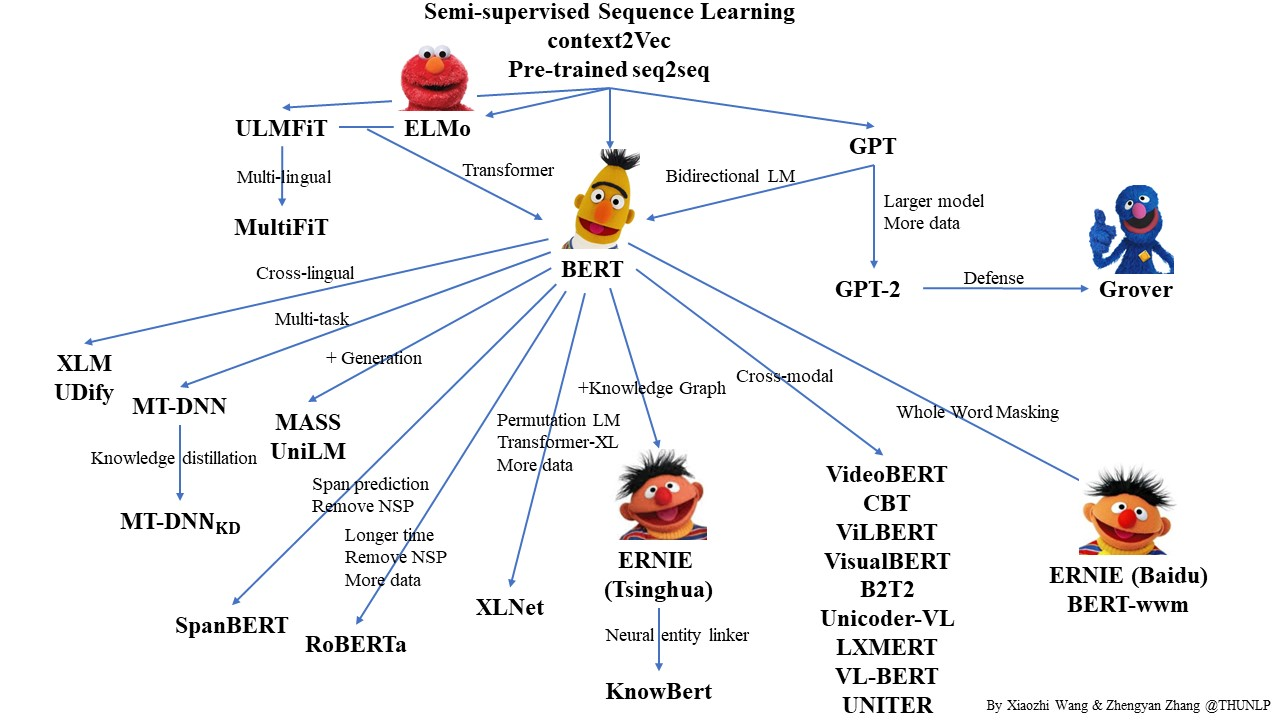

**How BERT is better than Word2vec?**

`BERT` and `Word2ve`c both are famous for generating `word-embeddings` for different NLP tasks. But somehow BERT outperforms over Word2vec. The reasons are discussed below:

**Contextual Understanding:** BERT model can capture the `contextual meaning` of each `word` based on their surrounding words in a sentence. So, BERT can generate contextual word-embeddings. In the other hand, Word2vec is not capable to capture context of the words so that it generates static embeddings only. So, BERT model is more informative and effective for NLP tasks like sentiment analysis, text classification etc. where contextual meanings need to be considered.

**Pre-training and Transfer Learning:** BERT is `pre-trained` on a massive amount of text data so that this model can `predict masked words` within sentences and gains a deep understanding of language semantics. Also we can perform fine-tuning for specific downstream NLP tasks. But Word2vec model is only trained using a simpler prediction task of predicting words within a fixed window and there is no default way to perform fine-tuning on it.

**Out-of-Vocabulary Handling:** BERT can effectively handle `out-of-vocabulary (OOV)` words by breaking them down into `sub-word` tokens using sub-word tokenization techniques like Word Piece or Byte Pair Encoding (BPE). But Word2vec doesn’t has any sub-word tokenization feature so, it can’t handle OOV effectively.

**Polysemy Handling:** When single word carries multiple meanings(sarcasm or irony) it can be called `polysemy`. BERT can effectively handle it as this model captures the whole context of the sentence. Word2vec model may not capture all meanings as it assigns only one vector for one word.

**BERT has inspired many variants:**

**RoBERTa:** Showed that the original BERT was undertrained. RoBERTa is trained longer, on more data; with bigger batches and longer sequences; without NSP; and dynamically changes the masking pattern.

**ALBERT:** Uses parameter reduction techniques to yield a smaller model. To utilize inter-sentence coherence, ALBERT uses Sentence-Order Prediction (SOP) instead of NSP.

**XLNet:** Doesn't do masking but uses permutation to capture bidirectional context. It combines the best of denoising autoencoding of BERT and autoregressive language modelling of Transformer-XL.

**MT-DNN:** Uses BERT with additional multi-task training on NLU tasks. Cross-task data leads to regularization and more general representations.

In [ ]:
# Set a random seed
random_seed = 42
random.seed(random_seed)

# Set a random seed for PyTorch (for GPU as well)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

In [ ]:
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
class sentence_embedding_Bert():

 def encoding(texts):
  # Tokenize and encode text using batch_encode_plus
  # The function returns a dictionary containing the token IDs and attention masks
  encoding = tokenizer.batch_encode_plus(
    texts,                    # List of input texts
    padding=True,              # Pad to the maximum sequence length
    truncation=True,           # Truncate to the maximum sequence length if necessary
    return_tensors='pt',      # Return PyTorch tensors
    add_special_tokens=True    # Add special tokens CLS and SEP
  )

  input_ids = encoding['input_ids']  # Token IDs
  # print input IDs
  print(f"Input ID: {input_ids}")
  attention_mask = encoding['attention_mask']  # Attention mask
  # print attention mask
  print(f"Attention mask: {attention_mask}")
  return input_ids,attention_mask

 def word_embeddings(input_ids,attention_mask):
  # Generate embeddings using BERT model
  with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    word_embeddings = outputs.last_hidden_state  # This contains the embeddings

  # Output the shape of word embeddings
  print(f"Shape of Word Embeddings: {word_embeddings.shape}")
  return word_embeddings

 def sentence_embedding(word_embeddings):
    # Compute the average of word embeddings to get the sentence embedding
    sentence_embedding = word_embeddings.mean(dim=1)  # Average pooling along the sequence length dimension

    # Print the sentence embedding
    print("Sentence Embedding:")
    print(sentence_embedding)

    # Output the shape of the sentence embedding
    print(f"Shape of Sentence Embedding: {sentence_embedding.shape}")
    return sentence_embedding

In [ ]:
print('train_x :')
input_ids_train_x, attention_mask_train_x = sentence_embedding_Bert.encoding(train_x)
print('train_y :')
input_ids_train_y, attention_mask_train_y = sentence_embedding_Bert.encoding(train_y)

train_x :
Input ID: tensor([[  101,  2197,  2176,  ...,     0,     0,     0],
        [  101, 16599,  3117,  ...,     0,     0,     0],
        [  101,  2470,  2048,  ...,     0,     0,     0],
        ...,
        [  101,  2892, 27354,  ...,     0,     0,     0],
        [  101, 17908,  3463,  ...,     0,     0,     0],
        [  101,  3259,  5136,  ...,     0,     0,     0]])
Attention mask: tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
train_y :
Input ID: tensor([[  101,  4162,   102],
        [  101, 19875,   102],
        [  101,  4162,   102],
        [  101,  4162,   102],
        [  101,  4162,   102],
        [  101,  4162,   102],
        [  101,  4162,   102],
        [  101,  4162,   102],
        [  101,  4162,   102],
        [  101, 19875,   102],
        [  101, 19875,   102],
        [  101,  4162, 

In [ ]:
print('train_x :')
word_embeddings_train_x = sentence_embedding_Bert.word_embeddings(input_ids_train_x, attention_mask_train_x)
print('train_y :')
word_embeddings_train_y = sentence_embedding_Bert.word_embeddings(input_ids_train_y, attention_mask_train_y)

train_x :
Shape of Word Embeddings: torch.Size([64, 234, 768])
train_y :
Shape of Word Embeddings: torch.Size([64, 3, 768])


In [ ]:
print('train_x :')
sentence_embedding_train_x = sentence_embedding_Bert.sentence_embedding(word_embeddings_train_x)
print('train_y :')
sentence_embedding_train_y = sentence_embedding_Bert.sentence_embedding(word_embeddings_train_y)

train_x :
Sentence Embedding:
tensor([[-0.0333,  0.1316,  0.3727,  ..., -0.2149,  0.0253, -0.1442],
        [-0.2536, -0.0379,  0.4983,  ..., -0.2869, -0.2557,  0.1231],
        [-0.3220, -0.0478,  0.3680,  ..., -0.3170, -0.1233, -0.0506],
        ...,
        [-0.1932, -0.0178,  0.4239,  ..., -0.3726, -0.1318,  0.2446],
        [-0.2823, -0.0036,  0.4357,  ..., -0.4108, -0.0553,  0.0760],
        [-0.4002,  0.0357,  0.4692,  ..., -0.2631, -0.1896,  0.1041]])
Shape of Sentence Embedding: torch.Size([64, 768])
train_y :
Sentence Embedding:
tensor([[ 0.0843,  0.1050, -0.2457,  ..., -0.0383, -0.2132,  0.1298],
        [-0.0229, -0.2672, -0.0320,  ...,  0.2991, -0.0759, -0.1458],
        [ 0.0843,  0.1050, -0.2457,  ..., -0.0383, -0.2132,  0.1298],
        ...,
        [ 0.0843,  0.1050, -0.2457,  ..., -0.0383, -0.2132,  0.1298],
        [ 0.0843,  0.1050, -0.2457,  ..., -0.0383, -0.2132,  0.1298],
        [-0.0229, -0.2672, -0.0320,  ...,  0.2991, -0.0759, -0.1458]])
Shape of Sentence Emb

In [ ]:
#To remove heavy load from RAM
word_embeddings_train_x = ""
word_embeddings_train_y = ""

In [ ]:
model_1 = LinearRegression()
model_1.fit(sentence_embedding_train_x, sentence_embedding_train_y)

model_2 = xgb.XGBRegressor()
model_2.fit(sentence_embedding_train_x, sentence_embedding_train_y)

model_3 = RandomForestRegressor()
model_3.fit(sentence_embedding_train_x, sentence_embedding_train_y)

RandomForestRegressor()

In [ ]:
from torch.utils.data import DataLoader

batch_size = 16
test_dataloader = DataLoader(text_x, batch_size=batch_size)

pred_final = []
counter = 0
for batch in test_dataloader:
    counter +=1
    print('batch :',counter)
    input_ids_text_x, attention_mask_text_x = sentence_embedding_Bert.encoding(batch)
    print('word_embeddings_text_x :')
    word_embeddings_text_x = sentence_embedding_Bert.word_embeddings(input_ids_text_x, attention_mask_text_x)

    print('sentence_embedding_text_x :')
    sentence_embedding_text_x = sentence_embedding_Bert.sentence_embedding(word_embeddings_text_x)

    pred_1 = (model_1.predict(sentence_embedding_text_x))
    pred_2 = (model_2.predict(sentence_embedding_text_x))
    pred_3 = (model_3.predict(sentence_embedding_text_x))
    pred_final.append((pred_1+pred_2+pred_3)/3.0)


Streaming output truncated to the last 5000 lines.
        [  101,  5193, 12103,  ...,     0,     0,     0]])
Attention mask: tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
word_embeddings_text_x :
Shape of Word Embeddings: torch.Size([16, 170, 768])
sentence_embedding_text_x :
Sentence Embedding:
tensor([[-0.0754, -0.0810,  0.3837,  ..., -0.2980, -0.2066,  0.1505],
        [-0.1344,  0.0322,  0.3659,  ..., -0.3891, -0.2430,  0.1998],
        [-0.4714,  0.1447,  0.5409,  ..., -0.3462, -0.1351,  0.2078],
        ...,
        [-0.2992,  0.2615,  0.4128,  ..., -0.4164, -0.3308,  0.1602],
        [-0.1554, -0.0253,  0.4130,  ..., -0.1176, -0.1625,  0.0952],
        [-0.2160,  0.1837,  0.3403,  ..., -0.2392, -0.1880,  0.1911]])
Shape of Sentence Embedding: torch.Size([16, 768])
batch : 65
Input ID: tensor([[  101,  2898,  

In [ ]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

predictions=[]
for i in range(0,len(pred_final)):
  for j in range(0,len(pred_final[0])):
    pred_final_binary = sigmoid(pred_final[i][j])
    y_pred = np.where(pred_final_binary >= 0.5, 1, 0)
    y_pred = np.mean(y_pred)
    y_pred = int(np.where(y_pred >= 0.5, 1, 0))
    predictions.append(y_pred)

In [ ]:
data = {'prediction': predictions}
df = pd.DataFrame(data)
df = df.replace({1: 'ML', 0: 'Applied'})
print(df)

     prediction
0            ML
1            ML
2            ML
3            ML
4            ML
...         ...
3931         ML
3932         ML
3933    Applied
3934         ML
3935         ML

[3936 rows x 1 columns]


#Doc to vec


Now words maintain logical (grammatical) structure but documents don’t have any logical structures. To solve this problem another vector (Paragraph ID) needs to add with word2vec model. This is the only difference between word2vec and doc2vec.

Doc2Vec, an extension of Word2Vec, takes into account the entire context of a document or sentence. It assigns a unique vector to each document or sentence and trains the model to predict words in that context. This approach captures the document’s semantics and is useful for various NLP tasks like document retrieval and text classification.

Doc2Vec is a neural network-based approach that learns the distributed representation of documents. It is an unsupervised learning technique that maps each document to a fixed-length vector in a high-dimensional space. The vectors are learned in such a way that similar documents are mapped to nearby points in the vector space. This enables us to compare documents based on their vector representation and perform tasks such as document classification, clustering, and similarity analysis.

There are two main variants of the Doc2Vec approach:

*   Distributed Memory (DM)
*   Distributed Bag of Words (DBOW)


**Distributed Memory (DM)**
Distributed Memory is a variant of the Doc2Vec model, which is an extension of the popular Word2Vec model. The basic idea behind Distributed Memory is to learn a fixed-length vector representation for each piece of text data (such as a sentence, paragraph, or document) by taking into account the context in which it appears.

In [ ]:
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(clean_corpus)]

In [ ]:
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(
                alpha=alpha,
                min_alpha=0.00025,
                min_count=1,
                dm =1)

model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=2)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration

In [ ]:
model= Doc2Vec.load("d2v.model")
#to find the vector of a document which is not in training data
test_data = word_tokenize(train_x[0])
v1 = model.infer_vector(test_data)
print("V1_infer", v1)

V1_infer [-0.03758054  0.02568696 -0.03992842 -0.01814553 -0.01762319 -0.04328469
  0.04504128  0.0338745  -0.05441011 -0.00281706 -0.04971231 -0.03887971
  0.00205745  0.01685294 -0.021969   -0.04600018  0.00517138 -0.04854091
 -0.03911963 -0.05021442  0.0247846  -0.00153948  0.02770438  0.00683475
  0.0580359  -0.02192453 -0.04213136 -0.04304724 -0.08837491 -0.00831805
  0.12424687  0.0819278   0.00052581  0.04346434  0.01017541  0.06574767
 -0.01592815 -0.09679908 -0.0038857  -0.08405956  0.00927125 -0.0254544
 -0.00016774 -0.07592933  0.01378673 -0.00369515 -0.02885058  0.02136388
  0.00148144 -0.01579462 -0.00455897 -0.03413103 -0.01672141 -0.01394174
 -0.05757008  0.06830165  0.02644075 -0.00962889 -0.04185526  0.01257101
  0.02642145  0.07020414 -0.011938   -0.00575145 -0.02377005  0.01924511
  0.02991391  0.02501743 -0.03131574  0.06154997 -0.05926835  0.03657225
 -0.00334225 -0.03227901  0.01687417  0.07065118  0.01977045 -0.01724134
  0.00880405  0.05032904 -0.00217194 -0.014

In [ ]:
vector_train_x = [model.infer_vector( word_tokenize(text) ) for text in train_x]
vector_train_y = [model.infer_vector( word_tokenize(text) ) for text in train_y]
vector_test_x = [model.infer_vector( word_tokenize(text) ) for text in text_x]

In [ ]:
Y = vector_train_y
X = vector_train_x
X_test = vector_test_x

model_1 = LinearRegression()
model_1.fit(X, Y)

model_2 = xgb.XGBRegressor()
model_2.fit(X, Y)

model_3 = RandomForestRegressor()
model_3.fit(X, Y)

RandomForestRegressor()

In [ ]:
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)

pred_final = (pred_1+pred_2+pred_3)/3.0

In [ ]:
len(pred_final)

3936

In [ ]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

predictions=[]
for i in range(0,len(pred_final)):
    pred_final_binary = sigmoid(pred_final[i])
    y_pred = np.where(pred_final_binary >= 0.5, 1, 0)
    y_pred = np.mean(y_pred)
    y_pred = int(np.where(y_pred >= 0.5, 1, 0))
    predictions.append(y_pred)

In [ ]:
predictions

[0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,


In [ ]:
data = {'prediction': predictions}
df = pd.DataFrame(data)
df = df.replace({1: 'ML', 0: 'Applied'})
print(df)

     prediction
0       Applied
1       Applied
2       Applied
3       Applied
4            ML
...         ...
3931         ML
3932         ML
3933         ML
3934         ML
3935    Applied

[3936 rows x 1 columns]


In [ ]:
df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Hakaton-LLM/Ensemble/output.csv', index=False)

#Universal Sentence Encoder
Developed by Google, the Universal Sentence Encoder is a pre-trained model that provides embeddings for sentences and short texts. It utilizes a transformer-based architecture to encode sentences into fixed-size vectors. This model is versatile and can be used in various NLP applications, including semantic similarity and text classification.

The Universal Sentence Encoder makes getting sentence level embeddings as easy as it has historically been to lookup the embeddings for individual words. The sentence embeddings can then be trivially used to compute sentence level meaning similarity as well as to enable better performance on downstream classification tasks using less supervised training data.



In [ ]:
!pip install tensorflow-hub

In [ ]:
# import necessary libraries
import tensorflow_hub as hub

# Load pre-trained universal sentence encoder model
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
# Sentences for which you want to create embeddings,
# passed as an array in embed()
embeddings_train_x = embed(train_x)
embeddings_train_y = embed(train_y)
embeddings_text_x = embed(text_x)
print(embeddings_train_x.shape,embeddings_train_y.shape,embeddings_text_x.shape)

(64, 512) (64, 512) (3936, 512)


In [ ]:
X = embeddings_train_x
Y = embeddings_train_y

model_1 = LinearRegression()
model_1.fit(X, Y)

model_2 = xgb.XGBRegressor()
model_2.fit(X, Y)

model_3 = RandomForestRegressor()
model_3.fit(X, Y)

RandomForestRegressor()

In [ ]:
X_test = embeddings_text_x

pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)


pred_final = (pred_1+pred_2+pred_3)/3.0

In [ ]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

predictions=[]
for i in range(0,len(pred_final)):
    pred_final_binary = sigmoid(pred_final[i])
    y_pred = np.where(pred_final_binary >= 0.5, 1, 0)
    y_pred = np.mean(y_pred)
    y_pred = int(np.where(y_pred >= 0.5, 1, 0))
    predictions.append(y_pred)

In [ ]:
data = {'prediction': predictions}
df = pd.DataFrame(data)
df = df.replace({1: 'ML', 0: 'Applied'})
print(df)

     prediction
0            ML
1            ML
2       Applied
3            ML
4       Applied
...         ...
3931         ML
3932    Applied
3933         ML
3934         ML
3935         ML

[3936 rows x 1 columns]


#Sentence-BERT
Sentence-BERT is an extension of BERT tailored for sentence embeddings. It fine-tunes the BERT model on a siamese and triplet network structure, enabling it to generate semantically meaningful sentence embeddings. This approach has proven effective for tasks like semantic search and paraphrase identification.

The Universal Sentence Encoder (Cer et al., 2018) (USE) is a model that encodes text into 512-dimensional embeddings. These embeddings can then be used as inputs to natural language processing tasks such as sentiment classification and textual similarity analysis.

This module is a TensorFlow.js GraphModel converted from the USE lite (module on TFHub), a lightweight version of the original. The lite model is based on the Transformer (Vaswani et al, 2017) architecture, and uses an 8k word piece vocabulary.

In [ ]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 2.9 MB/s eta 0:00:00


In [ ]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')  # multi-language model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/471M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
embedding_train_x = model.encode(train_x, convert_to_tensor=False)
embedding_train_y = model.encode(train_y, convert_to_tensor=False)
print(embedding_train_x.shape,embedding_train_y.shape)

(64, 384) (64, 384)


In [ ]:
Y = embedding_train_x
X = embedding_train_y

model_1 = LinearRegression()
model_1.fit(X, Y)

model_2 = xgb.XGBRegressor()
model_2.fit(X, Y)

model_3 = RandomForestRegressor()
model_3.fit(X, Y)

RandomForestRegressor()

In [ ]:
from torch.utils.data import DataLoader

batch_size = 16
test_dataloader = DataLoader(text_x, batch_size=batch_size)

pred_final = []
counter = 0
for batch in test_dataloader:
    counter +=1
    print('batch :',counter)
    embedding_text_x = model.encode(batch, convert_to_tensor=False)

    pred_1 = (model_1.predict(embedding_text_x))
    pred_2 = (model_2.predict(embedding_text_x))
    pred_3 = (model_3.predict(embedding_text_x))
    pred_final.append((pred_1+pred_2+pred_3)/3.0)

batch : 1
batch : 2
batch : 3
batch : 4
batch : 5
batch : 6
batch : 7
batch : 8
batch : 9
batch : 10
batch : 11
batch : 12
batch : 13
batch : 14
batch : 15
batch : 16
batch : 17
batch : 18
batch : 19
batch : 20
batch : 21
batch : 22
batch : 23
batch : 24
batch : 25
batch : 26
batch : 27
batch : 28
batch : 29
batch : 30
batch : 31
batch : 32
batch : 33
batch : 34
batch : 35
batch : 36
batch : 37
batch : 38
batch : 39
batch : 40
batch : 41
batch : 42
batch : 43
batch : 44
batch : 45
batch : 46
batch : 47
batch : 48
batch : 49
batch : 50
batch : 51
batch : 52
batch : 53
batch : 54
batch : 55
batch : 56
batch : 57
batch : 58
batch : 59
batch : 60
batch : 61
batch : 62
batch : 63
batch : 64
batch : 65
batch : 66
batch : 67
batch : 68
batch : 69
batch : 70
batch : 71
batch : 72
batch : 73
batch : 74
batch : 75
batch : 76
batch : 77
batch : 78
batch : 79
batch : 80
batch : 81
batch : 82
batch : 83
batch : 84
batch : 85
batch : 86
batch : 87
batch : 88
batch : 89
batch : 90
batch : 91
batch : 

In [ ]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

predictions=[]
for i in range(0,len(pred_final)):
  for j in range(0,len(pred_final[0])):
    pred_final_binary = sigmoid(pred_final[i][j])
    y_pred = np.where(pred_final_binary >= 0.5, 1, 0)
    y_pred = np.mean(y_pred)
    y_pred = int(np.where(y_pred >= 0.5, 1, 0))
    predictions.append(y_pred)

<ipython-input-57-bd3818e5b2c5>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


In [ ]:
data = {'prediction': predictions}
df = pd.DataFrame(data)
df = df.replace({1: 'ML', 0: 'Applied'})
print(df)

     prediction
0            ML
1            ML
2            ML
3            ML
4            ML
...         ...
3931         ML
3932         ML
3933    Applied
3934         ML
3935         ML

[3936 rows x 1 columns]




#InferSent
InferSent is a supervised model that learns sentence embeddings by training on labeled data. It uses a bi-directional LSTM network to encode sentences and has shown excellent performance in various NLP tasks.

The structure comprises two components:

**Sentence Encoder**

The first is a sentence encoder responsible for receiving word vectors and transforming sentences into encoded vectors.
InferSent starts with pre-trained word embeddings. Words are embedded into continuous vector representations.
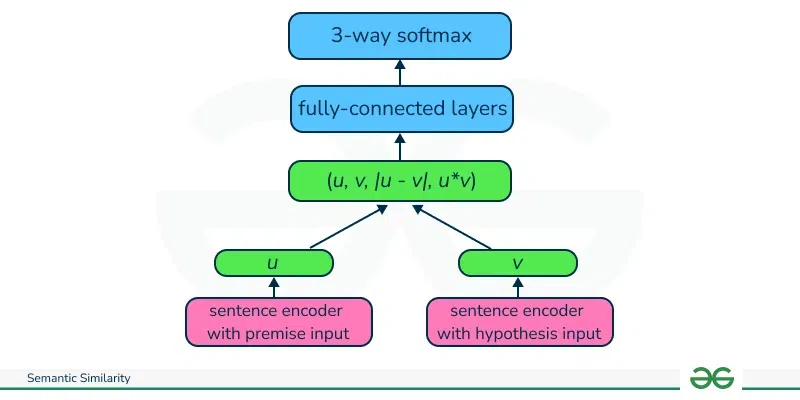
These embeddings serve as the input to the bi-directional LSTM that is capable of capturing sequential information and dependencies in data.
After processing the input sentence through the bi-directional LSTM, a pooling layer is applied to obtain a fixed-size vector representation of the entire sentence. Common pooling techniques include max pooling, mean pooling, or concatenation of the final hidden states.

**Classifier**

The pooled sentence representation is fed through one or more fully connected layers.

These layers serve as the classifier part whick that takes the pooled encoded vectors as input and generates a classification, identifying whether the relationship between the sentences is entailment, contradiction, or neutral.
3 matching methods are applied to extract relations between pair of sentences u and v.

concatenation of the two representations (u, v)

element-wise product u * v

element-wise difference |u — v |

The resulting vector is fed into a 3-class classifier (entailment, contradiction, and neutral) consisting of multiple fully connected layers followed by a SoftMax layer.

First, we need to build the infersent model. The below class does that.

In [ ]:
#Infersenct model class # copied from infersent github

%load_ext autoreload
%autoreload 2
%matplotlib inline
from random import randint
import numpy as np
import torch
import time
import torch.nn as nn
class InferSent(nn.Module):

	def __init__(self, config):
		super(InferSent, self).__init__()
		self.bsize = config['bsize']
		self.word_emb_dim = config['word_emb_dim']
		self.enc_lstm_dim = config['enc_lstm_dim']
		self.pool_type = config['pool_type']
		self.dpout_model = config['dpout_model']
		self.version = 1 if 'version' not in config else config['version']

		self.enc_lstm = nn.LSTM(self.word_emb_dim, self.enc_lstm_dim, 1,
								bidirectional=True, dropout=self.dpout_model)

		assert self.version in [1, 2]
		if self.version == 1:
			self.bos = '<s>'
			self.eos = '</s>'
			self.max_pad = True
			self.moses_tok = False
		elif self.version == 2:
			self.bos = '<p>'
			self.eos = '</p>'
			self.max_pad = False
			self.moses_tok = True

	def is_cuda(self):
		# either all weights are on cpu or they are on gpu
		return self.enc_lstm.bias_hh_l0.data.is_cuda

	def forward(self, sent_tuple):
		# sent_len: [max_len, ..., min_len] (bsize)
		# sent: (seqlen x bsize x worddim)
		sent, sent_len = sent_tuple

		# Sort by length (keep idx)
		sent_len_sorted, idx_sort = np.sort(sent_len)[::-1], np.argsort(-sent_len)
		sent_len_sorted = sent_len_sorted.copy()
		idx_unsort = np.argsort(idx_sort)

		idx_sort = torch.from_numpy(idx_sort).cuda() if self.is_cuda() \
			else torch.from_numpy(idx_sort)
		sent = sent.index_select(1, idx_sort)

		# Handling padding in Recurrent Networks
		sent_packed = nn.utils.rnn.pack_padded_sequence(sent, sent_len_sorted)
		sent_output = self.enc_lstm(sent_packed)[0] # seqlen x batch x 2*nhid
		sent_output = nn.utils.rnn.pad_packed_sequence(sent_output)[0]

		# Un-sort by length
		idx_unsort = torch.from_numpy(idx_unsort).cuda() if self.is_cuda() \
			else torch.from_numpy(idx_unsort)
		sent_output = sent_output.index_select(1, idx_unsort)

		# Pooling
		if self.pool_type == "mean":
			sent_len = torch.FloatTensor(sent_len.copy()).unsqueeze(1).cuda()
			emb = torch.sum(sent_output, 0).squeeze(0)
			emb = emb / sent_len.expand_as(emb)
		elif self.pool_type == "max":
			if not self.max_pad:
				sent_output[sent_output == 0] = -1e9
			emb = torch.max(sent_output, 0)[0]
			if emb.ndimension() == 3:
				emb = emb.squeeze(0)
				assert emb.ndimension() == 2

		return emb

	def set_w2v_path(self, w2v_path):
		self.w2v_path = w2v_path

	def get_word_dict(self, sentences, tokenize=True):
		# create vocab of words
		word_dict = {}
		sentences = [s.split() if not tokenize else self.tokenize(s) for s in sentences]
		for sent in sentences:
			for word in sent:
				if word not in word_dict:
					word_dict[word] = ''
		word_dict[self.bos] = ''
		word_dict[self.eos] = ''
		return word_dict

	def get_w2v(self, word_dict):
		assert hasattr(self, 'w2v_path'), 'w2v path not set'
		# create word_vec with w2v vectors
		word_vec = {}
		with open(self.w2v_path) as f:
			for line in f:
				word, vec = line.split(' ', 1)
				if word in word_dict:
					word_vec[word] = np.fromstring(vec, sep=' ')
		print('Found %s(/%s) words with w2v vectors' % (len(word_vec), len(word_dict)))
		return word_vec

	def get_w2v_k(self, K):
		assert hasattr(self, 'w2v_path'), 'w2v path not set'
		# create word_vec with k first w2v vectors
		k = 0
		word_vec = {}
		with open(self.w2v_path) as f:
			for line in f:
				word, vec = line.split(' ', 1)
				if k <= K:
					word_vec[word] = np.fromstring(vec, sep=' ')
					k += 1
				if k > K:
					if word in [self.bos, self.eos]:
						word_vec[word] = np.fromstring(vec, sep=' ')

				if k > K and all([w in word_vec for w in [self.bos, self.eos]]):
					break
		return word_vec

	def build_vocab(self, sentences, tokenize=True):
		assert hasattr(self, 'w2v_path'), 'w2v path not set'
		word_dict = self.get_word_dict(sentences, tokenize)
		self.word_vec = self.get_w2v(word_dict)
		print('Vocab size : %s' % (len(self.word_vec)))

	# build w2v vocab with k most frequent words
	def build_vocab_k_words(self, K):
		assert hasattr(self, 'w2v_path'), 'w2v path not set'
		self.word_vec = self.get_w2v_k(K)
		print('Vocab size : %s' % (K))

	def update_vocab(self, sentences, tokenize=True):
		assert hasattr(self, 'w2v_path'), 'warning : w2v path not set'
		assert hasattr(self, 'word_vec'), 'build_vocab before updating it'
		word_dict = self.get_word_dict(sentences, tokenize)

		# keep only new words
		for word in self.word_vec:
			if word in word_dict:
				del word_dict[word]

		# udpate vocabulary
		if word_dict:
			new_word_vec = self.get_w2v(word_dict)
			self.word_vec.update(new_word_vec)
		else:
			new_word_vec = []
		print('New vocab size : %s (added %s words)'% (len(self.word_vec), len(new_word_vec)))

	def get_batch(self, batch):
		# sent in batch in decreasing order of lengths
		# batch: (bsize, max_len, word_dim)
		embed = np.zeros((len(batch[0]), len(batch), self.word_emb_dim))

		for i in range(len(batch)):
			for j in range(len(batch[i])):
				embed[j, i, :] = self.word_vec[batch[i][j]]

		return torch.FloatTensor(embed)

	def tokenize(self, s):
		from nltk.tokenize import word_tokenize
		if self.moses_tok:
			s = ' '.join(word_tokenize(s))
			s = s.replace(" n't ", "n 't ") # HACK to get ~MOSES tokenization
			return s.split()
		else:
			return word_tokenize(s)

	def prepare_samples(self, sentences, bsize, tokenize, verbose):
		sentences = [[self.bos] + s.split() + [self.eos] if not tokenize else
					[self.bos] + self.tokenize(s) + [self.eos] for s in sentences]
		n_w = np.sum([len(x) for x in sentences])

		# filters words without w2v vectors
		for i in range(len(sentences)):
			s_f = [word for word in sentences[i] if word in self.word_vec]
			if not s_f:
				import warnings
				warnings.warn('No words in "%s" (idx=%s) have w2v vectors. \
							Replacing by "</s>"..' % (sentences[i], i))
				s_f = [self.eos]
			sentences[i] = s_f

		lengths = np.array([len(s) for s in sentences])
		n_wk = np.sum(lengths)
		if verbose:
			print('Nb words kept : %s/%s (%.1f%s)' % (
						n_wk, n_w, 100.0 * n_wk / n_w, '%'))

		# sort by decreasing length
		lengths, idx_sort = np.sort(lengths)[::-1], np.argsort(-lengths)
		sentences = np.array(sentences)[idx_sort]

		return sentences, lengths, idx_sort

	def encode(self, sentences, bsize=64, tokenize=True, verbose=False):
		tic = time.time()
		sentences, lengths, idx_sort = self.prepare_samples(
						sentences, bsize, tokenize, verbose)

		embeddings = []
		for stidx in range(0, len(sentences), bsize):
			batch = self.get_batch(sentences[stidx:stidx + bsize])
			if self.is_cuda():
				batch = batch.cuda()
			with torch.no_grad():
				batch = self.forward((batch, lengths[stidx:stidx + bsize])).data.cpu().numpy()
			embeddings.append(batch)
		embeddings = np.vstack(embeddings)

		# unsort
		idx_unsort = np.argsort(idx_sort)
		embeddings = embeddings[idx_unsort]

		if verbose:
			print('Speed : %.1f sentences/s (%s mode, bsize=%s)' % (
					len(embeddings)/(time.time()-tic),
					'gpu' if self.is_cuda() else 'cpu', bsize))
		return embeddings

	def visualize(self, sent, tokenize=True):

		sent = sent.split() if not tokenize else self.tokenize(sent)
		sent = [[self.bos] + [word for word in sent if word in self.word_vec] + [self.eos]]

		if ' '.join(sent[0]) == '%s %s' % (self.bos, self.eos):
			import warnings
			warnings.warn('No words in "%s" have w2v vectors. Replacing \
						by "%s %s"..' % (sent, self.bos, self.eos))
		batch = self.get_batch(sent)

		if self.is_cuda():
			batch = batch.cuda()
		output = self.enc_lstm(batch)[0]
		output, idxs = torch.max(output, 0)
		# output, idxs = output.squeeze(), idxs.squeeze()
		idxs = idxs.data.cpu().numpy()
		argmaxs = [np.sum((idxs == k)) for k in range(len(sent[0]))]

		# visualize model
		import matplotlib.pyplot as plt
		plt.figure(figsize=(12,12))
		x = range(len(sent[0]))
		y = [100.0 * n / np.sum(argmaxs) for n in argmaxs]
		plt.xticks(x, sent[0], rotation=45)
		plt.bar(x, y)
		plt.ylabel('%')
		plt.title('Visualisation of words importance')
		plt.show()

		return output, idxs, argmaxs


Next, we download the state-of-the-art fastText embeddings and download the pre-trained models.

In [ ]:
!mkdir fastText
!curl -Lo fastText/crawl-300d-2M.vec.zip https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
!unzip fastText/crawl-300d-2M.vec.zip -d fastText/

!mkdir encoder
!curl -Lo encoder/infersent2.pkl https://dl.fbaipublicfiles.com/infersent/infersent2.pkl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1453M  100 1453M    0     0  38.5M      0  0:00:37  0:00:37 --:--:-- 38.4M
Archive:  fastText/crawl-300d-2M.vec.zip
  inflating: fastText/crawl-300d-2M.vec  
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  146M  100  146M    0     0  93.1M      0  0:00:01  0:00:01 --:--:-- 93.1M


The code downloads the Punkt tokenizer model from NLTK, which is used for tokenization.

We then set the path (MODEL_PATH) to the pre-trained InferSent model file and loads its weights into an instance of the InferSent class.

We specify the path to our word embeddings(W2V_PATH)
The build_vocab_k_words method is called to load the embeddings for the K most frequent words (in this case, the top 100,000 words).

In [ ]:
MODEL_PATH = 'encoder/infersent2.pkl'
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
				'pool_type': 'max', 'dpout_model': 0.0}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))


W2V_PATH = 'fastText/crawl-300d-2M.vec'
model.set_w2v_path(W2V_PATH)

# Load embeddings of K most frequent words
model.build_vocab_k_words(K=100000)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Vocab size : 100000


In [ ]:
model.build_vocab(clean_corpus, tokenize=True)

Found 2017(/2072) words with w2v vectors
Vocab size : 2017


In [ ]:
embeddings = []
counter = 0
for sentense in train_x:
  counter += 1
  print(counter)
  sentense = str(sentense)
  embeddings.append(model.encode([sentense])[0])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64


In [ ]:
len(embeddings)

64

In [ ]:
embeddings[50].shape

(4096,)

In [ ]:
embeddings[10].shape

(4096,)

In [ ]:
Y = train_y
X = embeddings

model_1 = LinearRegression()
model_1.fit(X, Y)

model_2 = xgb.XGBRegressor()
model_2.fit(X, Y)

model_3 = RandomForestRegressor()
model_3.fit(X, Y)

RandomForestRegressor()

In [ ]:
from torch.utils.data import DataLoader

batch_size = 32
test_dataloader = DataLoader(text_x, batch_size=batch_size)

pred_final = []
counter = 0
for batch in test_dataloader:
    counter +=1
    print('batch :',counter)
    embeddings = []
    for sentense in batch:
      sentense = str(sentense)
      embeddings.append(model.encode([sentense])[0])

    pred_1 = (model_1.predict(embeddings))
    pred_2 = (model_2.predict(embeddings))
    pred_3 = (model_3.predict(embeddings))
    pred_final.append((pred_1+pred_2+pred_3)/3.0)

batch : 1
batch : 2
batch : 3
batch : 4
batch : 5
batch : 6
batch : 7
batch : 8
batch : 9
batch : 10
batch : 11
batch : 12
batch : 13
batch : 14
batch : 15
batch : 16
batch : 17
batch : 18
batch : 19
batch : 20
batch : 21
batch : 22
batch : 23
batch : 24
batch : 25
batch : 26
batch : 27
batch : 28
batch : 29
batch : 30
batch : 31
batch : 32
batch : 33
batch : 34
batch : 35
batch : 36
batch : 37
batch : 38
batch : 39
batch : 40
batch : 41
batch : 42
batch : 43
batch : 44
batch : 45
batch : 46
batch : 47
batch : 48
batch : 49
batch : 50
batch : 51
batch : 52
batch : 53
batch : 54
batch : 55
batch : 56
batch : 57
batch : 58
batch : 59
batch : 60
batch : 61
batch : 62
batch : 63
batch : 64
batch : 65
batch : 66
batch : 67
batch : 68
batch : 69
batch : 70
batch : 71
batch : 72
batch : 73
batch : 74
batch : 75
batch : 76
batch : 77
batch : 78
batch : 79
batch : 80
batch : 81
batch : 82
batch : 83
batch : 84
batch : 85
batch : 86
batch : 87
batch : 88
batch : 89
batch : 90
batch : 91
batch : 

In [ ]:
pred_final[100]

array([0.16305587, 0.20616768, 0.37230842, 0.20154808, 0.25823361,
       0.23334248, 0.15202609, 0.29438007, 0.21872291, 0.33060002,
       0.00907887, 0.37575586, 0.61055515, 0.47250363, 0.22258808,
       0.43964123, 0.11959551, 0.17051241, 0.33738178, 0.17644668,
       0.4910558 , 0.32783003, 0.18874922, 0.10862211, 0.20639711,
       0.30718502, 0.39016062, 0.32787579, 0.3894817 , 0.23295527,
       0.6110095 , 0.25979212])

In [ ]:
pred_final[0]

array([ 0.29722385,  0.39283871,  0.14311291,  0.17305686,  0.35793543,
        0.33485169,  0.25452832,  0.18102227, -0.02995956,  0.1940444 ,
        0.19885794,  0.48454919,  0.28606502,  0.32199854,  0.12202906,
        0.24370338,  0.29800807,  0.29314651,  0.20896217,  0.27184391,
        0.47587812,  0.4909805 ,  0.4471731 ,  0.14012346,  0.31465535,
        0.44420286,  0.34673484,  0.52477065,  0.20799655,  0.20691017,
        0.18242621,  0.10579902])

In [ ]:
len(pred_final[0])

16

In [ ]:
predictions=[]
for i in range(0,len(pred_final)):
  for j in range(0,batch_size):
    y_pred = int(np.where(pred_final[i][j] >= 0.5, 1, 0))
    predictions.append(y_pred)

In [ ]:
reverse_dict = {0:'ML', 1:'Applied'}

df = pd.DataFrame()
df['prediction'] = [reverse_dict[y] for y in predictions]
print(df)

     prediction
0            ML
1            ML
2            ML
3            ML
4            ML
...         ...
3931         ML
3932         ML
3933         ML
3934         ML
3935         ML

[3936 rows x 1 columns]


In [ ]:
counter = 0
for index, row in df.iterrows():
    if row['prediction'] != 'ML':
      counter +=1
      print(index , counter)

27 1
52 2
54 3
75 4
78 5
111 6
113 7
115 8
118 9
132 10
148 11
151 12
156 13
167 14
171 15
180 16
183 17
195 18
196 19
200 20
212 21
213 22
215 23
217 24
231 25
247 26
255 27
264 28
280 29
285 30
286 31
298 32
305 33
327 34
331 35
333 36
334 37
349 38
363 39
376 40
377 41
388 42
402 43
412 44
419 45
420 46
421 47
433 48
446 49
456 50
472 51
522 52
544 53
551 54
552 55
555 56
556 57
559 58
561 59
572 60
577 61
587 62
594 63
603 64
624 65
636 66
644 67
654 68
670 69
674 70
676 71
680 72
681 73
685 74
697 75
705 76
708 77
712 78
713 79
723 80
746 81
751 82
752 83
757 84
783 85
788 86
789 87
803 88
806 89
807 90
815 91
819 92
827 93
831 94
844 95
845 96
850 97
859 98
872 99
882 100
883 101
896 102
902 103
914 104
917 105
957 106
962 107
970 108
981 109
985 110
990 111
1007 112
1010 113
1017 114
1040 115
1042 116
1062 117
1063 118
1073 119
1076 120
1083 121
1089 122
1098 123
1099 124
1100 125
1101 126
1103 127
1104 128
1132 129
1151 130
1162 131
1163 132
1168 133
1173 134
1182 135
1188 136


In [ ]:
df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Hakaton-LLM/Ensemble/output.csv', index=False)